In [9]:
import sys, os, re, gzip, json, pickle, shutil, random
sys.path.append('../app')
from config import Config

from collections import Counter

import numpy as np

from scipy import stats

import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
config = Config()

# Load million tweet feature records, 1/2 troll, 1/2 normal user
## feats are a list of the tweet feature records
## labels are the specific tweet types (8 different)
## y is a list of 0 for NormalUser, 1 for troll (any of the 7 types)

## There are 7 troll tweet types
#### 'NormalUser': 500000, 
#### 'NewsFeed': 190952,
#### 'HashtagGamer': 37957,
#### 'LeftTroll': 86389,
#### 'RightTroll': 178738,
#### 'Unknown': 2516,
#### 'Fearmonger': 3109,
#### 'Commercial': 339

## The data can be used in binary classifiers (NormalUser, TrollUser) or
## or multiclass classifiers with classes of interest (NormalUser, LeftTroll, RightTroll, etc)

In [3]:
class_labels = ['Commercial', 'Fearmonger', 'HashtagGamer', 'LeftTroll', 
                'NewsFeed', 'NormalUser', 'RightTroll', 'Unknown']
lab2idx = {c:i for i,c in enumerate(class_labels)}

with gzip.open(config.feature_x_path, 'rb') as fz:
    feats = pickle.load(fz)

#string labels for all 8 types
type_labels = [feat['type'] for feat in feats]

#string binary labels
bin_labels = [l if l=='NormalUser' else 'TrollUser' for l in type_labels]

with open(config.feature_y_path, 'rb') as f:
    #int binary labels
    bin_y = pickle.load(f)
    
#int labels for all 8 types
type_y = [lab2idx[l] for l in type_labels]     

len(feats), len(bin_y)

(1000000, 1000000)

In [22]:
#a subset of data consisting of only NormalUser, LeftTroll, RightTroll
three_class_lab2int = {'LeftTroll':0, 'NormalUser':1, 'RightTroll':2}

three_class_feats = [f for f in feats if f['type'] in three_class_lab2int]
three_class_labels = [f['type'] for f in three_class_feats]
three_class_y = [three_class_lab2int[l] for l in three_class_labels]

len(three_class_feats), len(three_class_labels), len(three_class_y)

(765127, 765127, 765127)

### Example tweet feature record

{'type': 'NormalUser',
 'text': 'RT: <USER> Good to see Junie Browning back to being Junie Browning (VIDEO): <LINK>',
 'tokens': 'RT : <USER> Good to see Junie Browning back to being Junie Browning ( VIDEO ): <LINK>',
 'lemmas': 'rt :  good to see junie browning back to be junie browning ( video ): ',
 'pos': 'NNP : NFP NNP XX JJ TO VB NNP NNP RB IN VBG NNP NNP -LRB- NNP : NFP NNP ADD',
 'phrases': 'Junie_Browning Junie_Browning',
 'entities': ['Junie_Browning:PERSON'],
 'ent_types': ['PERSON'],
 'hashtags': [],
 'oov_words': 'rt junie junie ):',
 'emoji_ratio': 0.0,
 'link_ratio': 0.047619047619047616,
 'user_ratio': 0.047619047619047616,
 'oov_ratio': 0.3076923076923077}

# Experiment with text data type: lemmas vs tokens
### Hypothesis: Lemmas may work a tiny bit better since there is less 'noise', more generality

In [8]:
lemmas = [f['lemmas'].strip() for f in feats]
tokens = [f['tokens'].strip() for f in feats]

# Experiment with Count vs TF-IDF Vectorizer
### Hypothesis: TF-IDF will work better because it captures more information

In [31]:
#limit vocab to 50K
count_lemma_vectorizer = CountVectorizer(max_features=50000, stop_words="english")
count_lemmas = count_lemma_vectorizer.fit_transform(lemmas)
count_lemma_vocab = count_lemma_vectorizer.get_feature_names()

In [32]:
count_token_vectorizer = CountVectorizer(max_features=50000, stop_words="english")
count_tokens = count_token_vectorizer.fit_transform(tokens)
count_token_vocab = count_token_vectorizer.get_feature_names()

In [28]:
tfidf_lemma_vectorizer = TfidfVectorizer(max_features=50000, stop_words="english")
tfidf_lemmas = tfidf_lemma_vectorizer.fit_transform(lemmas)
tfidf_lemma_vocab = tfidf_lemma_vectorizer.get_feature_names()

In [30]:
tfidf_token_vectorizer = TfidfVectorizer(max_features=50000, stop_words="english")
tfidf_tokens = tfidf_token_vectorizer.fit_transform(tokens)
tfidf_token_vocab = tfidf_token_vectorizer.get_feature_names()

# Experiment with Models: Logistic Regression, SVM, MLP
## With and without LSA

## Logistic Regression

In [54]:
def train_model(model, vecs, y, vocab, test_size=50000, target_names=['NormalUser', 'TrollUser'], print_words=True):
    model.fit(vecs[test_size:,:], np.array(y[test_size:]))
    print(model.score(vecs[:test_size,:], np.array(y[:test_size])))

    preds = model.predict(vecs[:test_size,:])
    print(classification_report(y[:test_size], preds, digits=4, target_names=target_names))

    if print_words:
        most_important_token_idx = np.argsort(model.coef_)[0,-20:].tolist()[::-1]
        for i, word_idx in enumerate(most_important_token_idx):
            print(i, vocab[word_idx], model.coef_[0,word_idx])
            
    return model

In [39]:
# binary clf, lemmas, count
_ = train_model(LogisticRegression(max_iter=1000), count_lemmas, y, count_lemma_vocab)
#0.89342

0.89342
              precision    recall  f1-score   support

  NormalUser     0.9290    0.8510    0.8883     24901
   TrollUser     0.8636    0.9355    0.8981     25099

    accuracy                         0.8934     50000
   macro avg     0.8963    0.8933    0.8932     50000
weighted avg     0.8962    0.8934    0.8932     50000

0 youmightbealiberal 4.3858426585057275
1 10news 4.3283864393982565
2 nctime 4.292947416839117
3 com 4.25931383044808
4 upi 4.211453258375882
5 h1n1 4.138445009853254
6 hcr 3.9418866498769884
7 cofc 3.9147608992450342
8 mobsterworld 3.805541040817611
9 dawgfootball 3.7700775699476354
10 acorn 3.7580516653711853
11 proverbs29 3.6430005392311444
12 stupak 3.61718160953937
13 worldcupdraw 3.608160683977221
14 youraudiofix 3.547723645998759
15 awsr 3.500728357111782
16 proverbs28 3.487846609286266
17 www 3.4716157002615624
18 iranelection 3.463080762946041
19 2010 3.3321693228574483


In [34]:
# binary clf, tokens, count
_ = train_model(LogisticRegression(max_iter=1000), count_tokens, y, count_token_vocab)
#0.90816

0.90816
              precision    recall  f1-score   support

  NormalUser     0.9305    0.8814    0.9053     24901
   TrollUser     0.8882    0.9347    0.9109     25099

    accuracy                         0.9082     50000
   macro avg     0.9094    0.9081    0.9081     50000
weighted avg     0.9093    0.9082    0.9081     50000

0 upi 4.636514690647073
1 com 4.622545052792683
2 nctimes 4.47203526239084
3 cofc 4.383175598646752
4 10news 4.354558977010046
5 h1n1 4.146494043171691
6 mobsterworld 4.127724369718256
7 dbj 4.066388369078915
8 youmightbealiberal 3.8227931097524253
9 lastfm 3.7749073700640183
10 foreclosure 3.736630768437382
11 avenger 3.697198400456408
12 hcr 3.6796944224196038
13 2009 3.6450544062087644
14 dawgfootball 3.6242196605605628
15 39 3.5669350779558133
16 womensweardaily 3.4946393399896585
17 proverbs29 3.4933607056905776
18 acorn 3.492769886705013
19 youraudiofix 3.488277453932818


In [35]:
# binary clf, lemmas, tfidf
_ = train_model(LogisticRegression(max_iter=1000), tfidf_lemmas, y, tfidf_lemma_vocab)
#0.88984

0.88984
              precision    recall  f1-score   support

  NormalUser     0.9226    0.8501    0.8849     24901
   TrollUser     0.8620    0.9293    0.8944     25099

    accuracy                         0.8898     50000
   macro avg     0.8923    0.8897    0.8896     50000
weighted avg     0.8922    0.8898    0.8897     50000

0 com 13.421625803236504
1 2009 9.395464151891664
2 39 8.738918324249783
3 www 8.611289648123273
4 2010 8.172786729259094
5 blog 7.675349571912821
6 fb 6.609530286433576
7 hcr 6.447247012469866
8 h1n1 6.425108678373114
9 09 6.332877957660197
10 nov 5.710330152920245
11 nctime 5.631880324877094
12 palin 5.426365749976288
13 musicmonday 5.420917322027609
14 foreclosure 5.379294045692626
15 rt 5.369115075947315
16 mobsterworld 5.120490649098759
17 haha 5.0320294030783685
18 youmightbealiberal 4.994957759747037
19 upi 4.950659145885963


In [36]:
# binary clf, tokens, tfidf
_ = train_model(LogisticRegression(max_iter=1000), tfidf_tokens, y, tfidf_token_vocab)
#0.90018

0.90018
              precision    recall  f1-score   support

  NormalUser       0.93      0.87      0.90     24901
   TrollUser       0.88      0.93      0.90     25099

    accuracy                           0.90     50000
   macro avg       0.90      0.90      0.90     50000
weighted avg       0.90      0.90      0.90     50000

0 com 13.887017635129974
1 2009 9.890007468751206
2 39 9.257818974390885
3 2010 8.280480057705736
4 www 7.9576613631347035
5 blog 7.883568041513855
6 fb 6.758976296178951
7 h1n1 6.453492366643716
8 09 6.251204533844466
9 hcr 6.1202594826012735
10 nov 5.799687369587058
11 rt 5.76823372812789
12 nctimes 5.67748936383557
13 musicmonday 5.573613497429843
14 palin 5.337587146298601
15 hood 5.2493076266137075
16 foreclosure 5.185395467370479
17 mobsterworld 5.178732392031334
18 swine 5.006783810330849
19 upi 4.9861615407220885


In [50]:
#count, tokens is the best, test with LSA applied
svd = TruncatedSVD(128)
lsa_count_tokens = svd.fit_transform(count_tokens)
print(sum(svd.explained_variance_ratio_)) #0.24645964271429166

_ = train_model(LogisticRegression(max_iter=1000), lsa_count_tokens, y, tfidf_token_vocab, print_words=False)
#0.81056

0.3334549845999724
0.81056
              precision    recall  f1-score   support

  NormalUser     0.8335    0.7743    0.8028     24901
   TrollUser     0.7908    0.8465    0.8177     25099

    accuracy                         0.8106     50000
   macro avg     0.8121    0.8104    0.8103     50000
weighted avg     0.8121    0.8106    0.8103     50000



## SVM

In [42]:
_ = train_model(LinearSVC(dual=False), count_lemmas, y, count_lemma_vocab)
# dual=False is faster and converges better
# 0.89394

0.89394
              precision    recall  f1-score   support

  NormalUser     0.9308    0.8502    0.8887     24901
   TrollUser     0.8631    0.9373    0.8987     25099

    accuracy                         0.8939     50000
   macro avg     0.8970    0.8938    0.8937     50000
weighted avg     0.8969    0.8939    0.8937     50000

0 dawgfootball 3.2452281493021315
1 cagop 2.6832978568092662
2 youmightbealiberal 2.673320613336143
3 tbot 2.6671681706932366
4 skateboarder 2.6326518178799683
5 cofc 2.5130088125640513
6 10news 2.4700895099857494
7 thepatriotjournal 2.4661133055803224
8 kyl 2.435032095271059
9 8203 2.418746333957687
10 proverbs28 2.3540876687524563
11 awsr 2.3434239095276106
12 scozzafava 2.3255881390893816
13 dbj 2.310967813488037
14 volunteerism 2.2579636628728528
15 dawgfan 2.240973213395383
16 nctime 2.1950365909945466
17 selig 2.188031492796865
18 proverbs29 2.1561324356823484
19 woozy 2.1478675311522784


In [43]:
_ = train_model(LinearSVC(dual=False), count_tokens, y, count_token_vocab)
#0.907

0.907
              precision    recall  f1-score   support

  NormalUser     0.9309    0.8785    0.9039     24901
   TrollUser     0.8858    0.9353    0.9099     25099

    accuracy                         0.9070     50000
   macro avg     0.9083    0.9069    0.9069     50000
weighted avg     0.9083    0.9070    0.9069     50000

0 dbj 3.2698866652297616
1 fuks 3.070303341560899
2 dawgfootball 3.0055653092967387
3 scozzafava 2.921690645067436
4 volunteerism 2.8729634012401255
5 awsr 2.4928306454654217
6 dawgfan 2.486531113093628
7 tbot 2.4755586480613867
8 ecomates 2.4527426623285273
9 8203 2.4462106693824572
10 cofc 2.4408450717981567
11 mucha 2.399043927800512
12 infos 2.3772565466609663
13 psfk 2.3510035914271046
14 bleck 2.331353104435858
15 10news 2.31891784916978
16 cnen 2.316005401549625
17 proverbs28 2.2978747445031638
18 clenched 2.2800617533203753
19 selig 2.260057147723243


In [44]:
_ = train_model(LinearSVC(dual=False), tfidf_lemmas, y, tfidf_lemma_vocab)
#0.89576

0.89576
              precision    recall  f1-score   support

  NormalUser     0.9279    0.8573    0.8912     24901
   TrollUser     0.8684    0.9339    0.8999     25099

    accuracy                         0.8958     50000
   macro avg     0.8981    0.8956    0.8956     50000
weighted avg     0.8980    0.8958    0.8956     50000

0 com 4.809071570466758
1 10news 3.7571069090721396
2 nctime 3.6429370981461164
3 www 3.5748219599362834
4 h1n1 3.5148836677904054
5 youmightbealiberal 3.490992866182607
6 hcr 3.445556960274206
7 cofc 3.284805202430941
8 acorn 3.215815626933836
9 awsr 3.212007163291482
10 2009 3.2055118046380513
11 stupak 3.193024197919614
12 proverbs29 3.188243570824435
13 proverbs28 3.1807971573760927
14 39 3.084039016732025
15 worldcupdraw 2.99751445470195
16 kt 2.9562171705599267
17 youraudiofix 2.937619521541896
18 2010 2.9372032496451927
19 dawgfootball 2.919716155032816


In [45]:
_ = train_model(LinearSVC(dual=False), tfidf_tokens, y, tfidf_token_vocab)
#0.90296

0.90296
              precision    recall  f1-score   support

  NormalUser     0.9289    0.8719    0.8995     24901
   TrollUser     0.8802    0.9338    0.9062     25099

    accuracy                         0.9030     50000
   macro avg     0.9045    0.9028    0.9028     50000
weighted avg     0.9044    0.9030    0.9029     50000

0 com 5.309723097704451
1 10news 3.8903093685361507
2 nctimes 3.662223145469715
3 h1n1 3.5884829497666924
4 2009 3.4408457215116144
5 youmightbealiberal 3.388346649084513
6 39 3.3685086285759
7 hcr 3.3266301651809687
8 www 3.2849543154946534
9 acorn 3.2366139704121806
10 cofc 3.2258769898466486
11 proverbs29 3.2071755339686474
12 proverbs28 3.157443904149603
13 stupak 3.1238089461785488
14 2010 3.0432502031767115
15 dawgfootball 3.0182609081892404
16 awsr 3.010175653029679
17 clenched 2.950155755700129
18 worldcupdraw 2.9380472687063595
19 avenger 2.913710358933172


In [51]:
#again, count tokens did best, test with lsa
_ = train_model(LinearSVC(dual=False), lsa_count_tokens, y, count_token_vocab, print_words=False)
#

0.80528
              precision    recall  f1-score   support

  NormalUser     0.8343    0.7600    0.7954     24901
   TrollUser     0.7812    0.8502    0.8142     25099

    accuracy                         0.8053     50000
   macro avg     0.8077    0.8051    0.8048     50000
weighted avg     0.8076    0.8053    0.8049     50000



## MLP
### This MLP implementation is extremely slow, it may only be practical to train with LSA

In [48]:
_ = train_model(MLPClassifier(hidden_layer_sizes=(128), max_iter=1000), count_lemmas, y, count_lemma_vocab, print_words=False)

c:\ml\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.88704
              precision    recall  f1-score   support

  NormalUser     0.9234    0.8431    0.8814     24901
   TrollUser     0.8567    0.9306    0.8921     25099

    accuracy                         0.8870     50000
   macro avg     0.8901    0.8869    0.8868     50000
weighted avg     0.8899    0.8870    0.8868     50000



In [ ]:
_ = train_model(MLPClassifier(hidden_layer_sizes=(128), max_iter=1000), lsa_count_tokens, y, count_token_vocab, print_words=False)

## For LR and SVM, counts and tokens worked the best
### This indicates that individual words are very important for the classification task, and
###  any reduction in the word-level information is harmful

# Train on numerical features as opposed to text to discover their discriminating power
## These include oov_ratio, user_ratio, link_ratio, and emoji_ratio

In [64]:
num_data = []
for f in feats:
    num_data.append(np.array([f['emoji_ratio'], f['link_ratio'], f['oov_ratio'], f['user_ratio']]))
num_data = np.vstack(num_data)
num_data.shape

(1000000, 4)

## Train LR and view coefficients corresponding to the features

In [65]:
lr_model = train_model(LogisticRegression(max_iter=1000), num_data, y, None, print_words=False)
#0.60142

0.60142
              precision    recall  f1-score   support

  NormalUser     0.6315    0.4795    0.5451     24901
   TrollUser     0.5831    0.7224    0.6453     25099

    accuracy                         0.6014     50000
   macro avg     0.6073    0.6009    0.5952     50000
weighted avg     0.6072    0.6014    0.5954     50000



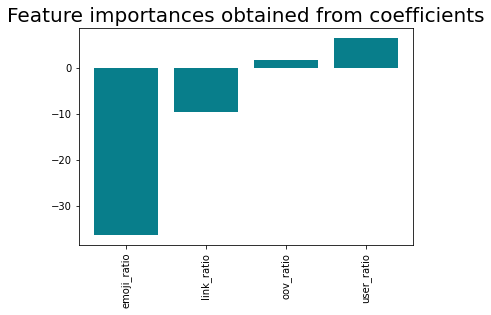

In [66]:
plt.bar(x=['emoji_ratio', 'link_ratio', 'oov_ratio', 'user_ratio'], height=lr_model.coef_[0].tolist(), color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Train SVM and view coefficients corresponding to the features

In [67]:
svm_model = train_model(LinearSVC(dual=False), num_data, y, None, print_words=False)
#0.60238

0.60238
              precision    recall  f1-score   support

  NormalUser     0.6333    0.4788    0.5453     24901
   TrollUser     0.5837    0.7250    0.6467     25099

    accuracy                         0.6024     50000
   macro avg     0.6085    0.6019    0.5960     50000
weighted avg     0.6084    0.6024    0.5962     50000



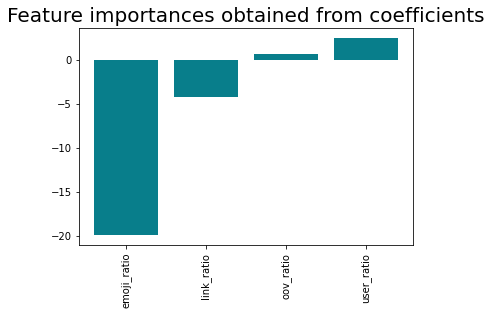

In [68]:
plt.bar(x=['emoji_ratio', 'link_ratio', 'oov_ratio', 'user_ratio'], height=svm_model.coef_[0].tolist(), color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### It's very interesting to note that the different models have essentially the same results in terms of feature importance. Both models weight emoji ratio very high, user and link mention ratios significantly, and OOV ratio low.

## Train MLP and view coefficients corresponding to the features

In [73]:
mlp_model = train_model(MLPClassifier(hidden_layer_sizes=(32)), num_data, y, None, print_words=False)

0.68484
              precision    recall  f1-score   support

  NormalUser     0.6476    0.8055    0.7180     24901
   TrollUser     0.7455    0.5651    0.6429     25099

    accuracy                         0.6848     50000
   macro avg     0.6965    0.6853    0.6804     50000
weighted avg     0.6967    0.6848    0.6803     50000



In [80]:
np.sum(mlp_model.coefs_[0], axis=1), np.sum(np.square(mlp_model.coefs_[0]), axis=1)

(array([-33.24466843,  -2.29873007,  -6.07032666, -23.5670362 ]),
 array([216.12569926, 409.9090455 , 206.54404541, 400.70689658]))

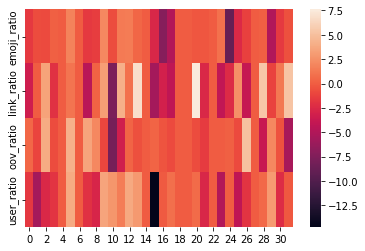

In [77]:
# feature importance is less clear in the mlp weights
f = sns.heatmap(mlp_model.coefs_[0], yticklabels=['emoji_ratio', 'link_ratio', 'oov_ratio', 'user_ratio'])

In [69]:
mlp_model = train_model(MLPClassifier(hidden_layer_sizes=(128)), num_data, y, None, print_words=False)
#0.69534

0.69534
              precision    recall  f1-score   support

  NormalUser     0.6713    0.7607    0.7132     24901
   TrollUser     0.7264    0.6305    0.6751     25099

    accuracy                         0.6953     50000
   macro avg     0.6989    0.6956    0.6942     50000
weighted avg     0.6990    0.6953    0.6941     50000



In [71]:
mlp_model = train_model(MLPClassifier(hidden_layer_sizes=(128, 128)), num_data, y, None, print_words=False)
#0.70034

0.70034
              precision    recall  f1-score   support

  NormalUser     0.6739    0.7717    0.7195     24901
   TrollUser     0.7354    0.6296    0.6784     25099

    accuracy                         0.7003     50000
   macro avg     0.7047    0.7006    0.6989     50000
weighted avg     0.7048    0.7003    0.6989     50000



# Test on Multiple Classes

In [81]:
three_class_tokens = [f['tokens'].strip() for f in three_class_feats]

In [82]:
three_class_count_token_vectorizer = CountVectorizer(max_features=50000, stop_words="english")
three_class_count_tokens = three_class_count_token_vectorizer.fit_transform(three_class_tokens)
three_class_count_token_vocab = three_class_count_token_vectorizer.get_feature_names()

In [84]:
three_class_lr = train_model(LogisticRegression(max_iter=1000), three_class_count_tokens, 
                             three_class_y, three_class_count_token_vocab, 
                             target_names=['LeftTroll', 'NormalUser', 'RightTroll'])
#0.87014

c:\ml\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.87014
              precision    recall  f1-score   support

   LeftTroll     0.7213    0.4778    0.5748      5699
  NormalUser     0.8912    0.9709    0.9293     32779
  RightTroll     0.8522    0.7775    0.8131     11522

    accuracy                         0.8701     50000
   macro avg     0.8216    0.7421    0.7724     50000
weighted avg     0.8628    0.8701    0.8621     50000

0 staywoke 4.147942408738573
1 newsonenow 3.6990970533375562
2 3rdeyeplug 3.5027086681922794
3 blackskinisnotacrime 3.4867700410969853
4 intelgroup 3.4845020370763917
5 beingblackis 3.417769930438236
6 blackpressday 3.304912691640562
7 4mysquad 3.2531473170620635
8 blacklivesmatter 3.159402505922667
9 htgawm 3.1190152195600147
10 nowplaying 3.041226070671908
11 twittergoons 3.033117880514568
12 blacktwitter 3.0135694528498367
13 ppchistory 2.958940760838011
14 derayformayor 2.9338139499220124
15 antipolicebrutalityday 2.9325469475928037
16 chicagoscanner 2.8804185239957145
17 ddark 2.858734025340564
18 w

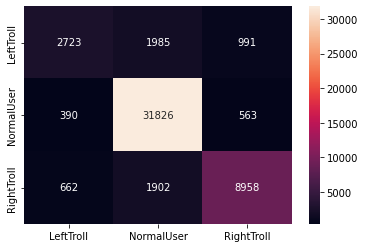

In [87]:
preds = three_class_lr.predict(three_class_count_tokens[:50000,:])
cm = confusion_matrix(three_class_y[:50000], preds)
f = sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=['LeftTroll', 'NormalUser', 'RightTroll'], 
                yticklabels=['LeftTroll', 'NormalUser', 'RightTroll'])

In [85]:
three_class_svm = train_model(LinearSVC(dual=False), three_class_count_tokens, 
                             three_class_y, three_class_count_token_vocab,
                             target_names=['LeftTroll', 'NormalUser', 'RightTroll'])
#0.86888

0.86888
              precision    recall  f1-score   support

   LeftTroll     0.7248    0.4667    0.5678      5699
  NormalUser     0.8883    0.9709    0.9278     32779
  RightTroll     0.8528    0.7776    0.8135     11522

    accuracy                         0.8689     50000
   macro avg     0.8220    0.7384    0.7697     50000
weighted avg     0.8615    0.8689    0.8604     50000

0 tmhs 2.591946473968497
1 newsonenow 2.5093230524728005
2 bgn 2.3793279972952637
3 worldlatinstar 2.3340970623263133
4 htgawm 2.2786820931301723
5 1000network 2.2431948538056985
6 afam 2.182743204276314
7 electorial 2.1751973593562783
8 cointelpro 2.1595334922620135
9 intelgroup 2.1355779692407184
10 3rdeyeplug 2.1212149144056207
11 mayaangeloufilm 2.0896918961873916
12 tbgwt 2.088839994238415
13 gohounds 2.086315130280119
14 boycottadogspurpose 2.0813527481430127
15 celebnazeem 2.0547007627772955
16 blackskinisnotacrime 2.0510450498477013
17 muhammadali 2.05058978635677
18 twittergoons 2.03813648186899

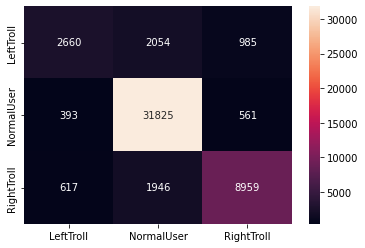

In [86]:
preds = three_class_svm.predict(three_class_count_tokens[:50000,:])
cm = confusion_matrix(three_class_y[:50000], preds)
f = sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=['LeftTroll', 'NormalUser', 'RightTroll'], 
                yticklabels=['LeftTroll', 'NormalUser', 'RightTroll'])

# Evaluate words important for distinguishing LeftTroll and RightTroll

In [88]:
tokens_2class = []
y_2class = []
class_cts = {'LeftTroll':0, 'RightTroll':0}
for i, feat in enumerate(feats):
    if (feat['type']=='LeftTroll' and class_cts['LeftTroll']<80000) or (feat['type']=='RightTroll' and class_cts['RightTroll']<80000):
        tokens_2class.append(feat['tokens'].strip())
        y_2class.append(1 if feat['type']=='RightTroll' else 0)
        class_cts[feat['type']]+=1

idx = list(range(len(y_2class)))
random.shuffle(idx)
tokens_2class = [tokens_2class[i] for i in idx]
y_2class = [y_2class[i] for i in idx]

class_cts, Counter(y_2class)

({'LeftTroll': 80000, 'RightTroll': 80000}, Counter({0: 80000, 1: 80000}))

In [89]:
tfidf_vectorizer = TfidfVectorizer(max_features=50000, stop_words="english")
tfidf_tokens = tfidf_vectorizer.fit_transform(tokens_2class)
vocab = tfidf_vectorizer.get_feature_names()

In [90]:
svm_tfidf = LinearSVC(dual=False)
svm_tfidf.fit(tfidf_tokens[:-5000,:], np.array(y_2class[:-5000]))
print(svm_tfidf.score(tfidf_tokens[-5000:,:], np.array(y_2class[-5000:])))

preds = svm_tfidf.predict(tfidf_tokens[-5000:,:])
print(classification_report(y_2class[-5000:], preds, target_names=['LeftTroll', 'RightTroll']))
#0.8104

0.8104
              precision    recall  f1-score   support

   LeftTroll       0.81      0.82      0.82      2552
  RightTroll       0.81      0.80      0.81      2448

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



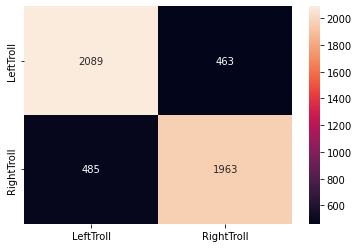

In [91]:
cm = confusion_matrix(y_2class[-5000:], preds)
f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=['LeftTroll', 'RightTroll'], yticklabels=['LeftTroll', 'RightTroll'])

In [92]:
# words that best distinguish Left from RightTroll
most_important_token_idx = np.argsort(svm_tfidf.coef_)[-100:][0].tolist()[::-1]
for i, word_idx in enumerate(most_important_token_idx):
    print(vocab[word_idx], svm_tfidf.coef_[0,word_idx])

enlist 5.346259508086625
realdonaldtrump 4.711930761505459
wiunion 4.049993065249572
maga 3.5192531735118746
dineshdsouza 3.4970534214325033
antifa 3.463088312490943
amb 3.4438916783026388
thingsmoretrustedthanhillary 3.4300460334863936
liberallogic 3.328140126072305
smallbusiness 3.1930634225320746
prayers4california 3.157017523959079
iamonfire 3.117732680832706
tisda 3.108539089685119
barbmuenchen 3.1081156679745443
soros 3.0876592542387016
newyork 3.050582497611805
bb4sp 3.009066644292257
ros 2.874207547301804
2a 2.8581652877477652
libtards 2.817828191459588
guns4ny 2.807319229377358
nocybercensorship 2.806608475599811
trumpbecause 2.7953858017538766
shembo 2.7633249679537615
dncleak 2.7497177311859944
happybirthdaygeorgewashington 2.734592347525329
showbiz 2.708010887040577
mitchellvii 2.7043176290264186
liberals 2.69066467494362
banislam 2.686788060860406
nogunsforcriminals 2.679338274091729
demndebate 2.649797433313119
trumptrain 2.644184492472799
trumpforpresident 2.621059587284

gartrelllinda 1.5081292386825906
eiffel 1.5068738212210966
2b 1.505920527603467
enlistment 1.5058925625081292
stow 1.5051059174372068
sjwlogic 1.504878840284237
latinoswithtrump 1.504227992090555
isis 1.5035982583899974
socialist 1.5009981704183788
march4trump 1.5007790588037262
marklevinshow 1.5007759374244827
politically 1.5003754017490123
shapiro 1.499179753515933
whines 1.498161723502624
boycottpepsi 1.4980151314395995
tapper 1.4979289674545968
trish_regan 1.497925338091198
coburn 1.49668847374082
sahara 1.4961127925428288
nears 1.4960436377859125
nbcnewsforum 1.4954874588781961
trumptrain45pac 1.4952432490641059
solongstoryshort 1.4951052195822154
artbasel 1.4948979410854228
sjws 1.4946871831093322
rogan 1.4930525465464726
alwaysactions 1.4924213888252849
epochtech 1.4922818770081774
spectre 1.4917810639669886
snp 1.4900996905319193
ammo 1.4896558373543023
bringbernieback 1.4890941867678311
artbasel2015 1.4887832578289248
kon__k 1.4886941860792993
caitlynjenner 1.487693240672773
l

spitta 1.296986889796772
ericholder 1.2966436589464947
dillon 1.2964744715895598
ingrahamangle 1.2959880151483771
socialjustice 1.2951304409223379
chafee 1.295129223383666
sqeezy 1.294436410585023
tens 1.2936974935154004
inauguralball 1.2932159800688559
cologne 1.2926125047679686
cruz2016 1.2925752464804376
paine 1.2923436505531156
pedophiles 1.2922504539831146
sweetatertot2 1.2921418200986
overs 1.2919251124508246
inaugural 1.291614086307242
pointless 1.2912553560411135
michaelkeyes 1.290386479406291
anon 1.2896218973735512
happymonday 1.2890466901790878
glut 1.2889499429000892
750 1.2882361282119443
robotic 1.28810476631328
unga2015 1.2871915097598623
waterprotectors 1.286906092108345
arlington 1.2864019571197396
murraywatt 1.285512448534403
iabc 1.2854329599579166
islamicstate 1.2853512384567767
republicanchick 1.285106913085094
powerfulanswers 1.2848834285292856
suffers 1.2842150302862998
stefanmolyneux 1.2834458872269672
explode 1.2833691741843076
bodyguards 1.2831952783665228
ope

recalling 1.1709921974358353
abcnews 1.170788382259342
famed 1.1706936076272956
doggy 1.1706126652468636
bandwidth 1.1705879880829637
dickingbimbos 1.17050112359687
unitedairlines 1.170240456339849
guantanamo 1.1701622244902197
mosques 1.1700440106416126
middleeast 1.169608271684513
lobotomized 1.169454095307139
pooch 1.169448165032818
moslems 1.1691601065069106
sarsour 1.1685131769426524
bicameral 1.168310578202627
sheriffclarke 1.1677335335754544
talcum 1.1675640164917833
mikepence 1.1672811929394
renewable 1.167078911462672
busted 1.1668820565635503
climatemarch 1.1666909611504446
hrcoriginalbirther 1.1665275287213606
sanctuarycity 1.1661489497497
sacks 1.166114481572618
cyprus 1.16607503939901
uknow 1.1657512451632408
sanders2016 1.1657287245205836
affluenza 1.165192533945093
unbelievers 1.164882324718317
genderreveal 1.1648501676199838
approved 1.1644820131085236
bevhillsantifa 1.1644474720841593
oscarsowhite 1.1641465607930437
hgtv 1.1632703429489064
wolfblitzer 1.163013144009325

exceed 1.091524248180392
judd 1.0915015329789075
birthright 1.0914826968155098
enforce 1.0910840674707007
johnkerry 1.0910462592969479
magicalquote 1.090990617985549
tickled 1.0908699194365217
tick 1.0907563962888138
64th 1.0904188699666937
vehicles 1.0900486309713613
soviet 1.0900264732320544
admiration 1.0899973532961875
graves 1.0894133325993847
crushed 1.0891992666734711
whiskypedia 1.0890762114454853
arbitrarily 1.0889922183410232
manners 1.0887758885276106
stumbling 1.08872550054448
jmhamiltonpublishing 1.0886028823543983
truely 1.0885816342470975
upvote 1.088530070758124
tenn 1.0884806520605659
dividing 1.088193350496106
bromley 1.088041259450061
emp 1.0879131492533867
earnest 1.0877633034725673
fremont 1.0875937575179702
procrastinate 1.08698347077138
nofilterjeb 1.0868060904334504
bklynmiddleton 1.0867870271160562
crook 1.0865791700220304
boycottnfl 1.0863318231338501
gpusa 1.0858795374879833
jevote 1.0858070141110212
takers 1.085710436472275
criminalizes 1.0856561895184464
su

elusive 1.025906578193164
wennington 1.025659141099251
sony 1.0255478221685208
riggedsystem 1.0255005523076541
tacitus 1.0254836564674459
hardware 1.0253097423134314
guarantees 1.0250640648435785
barnaby 1.025025085201792
wastes 1.0249991087843395
mattie 1.0249001390626613
whitening 1.0248098294920942
cull 1.02479856510513
bugliosi 1.0246309146989552
captains 1.0243449102628244
cchiz5 1.0243166912668236
tsarnaev 1.0242954974520808
hansen 1.0241350397792972
wearable 1.0239115810256432
chainmigration 1.0238156570114147
ariz 1.02380157141355
securetheborder 1.023592890749731
antiamerican 1.0233980629303305
ukraine 1.0231471656992168
gilmore 1.0231469816451468
freericky 1.0231327931878622
decorations 1.023047659637736
enriched 1.0224657205977656
paternity 1.022439644658579
skips 1.0224102830430313
hardcover 1.022079997362866
epictetus 1.0220524224650434
senblumenthal 1.0219248953834186
julius 1.0218648924839902
america1st 1.0217465166880648
smthing 1.0214776029110086
joshdcaplan 1.02131880

soars 0.9589379557978912
surfaces 0.9589301209419772
physician 0.9587781759497562
chokal 0.9586912625690873
reached 0.9584619763303348
the_trump_train 0.9583597263751211
flags 0.9582783601805404
hectormorenco 0.958218478552711
russianhackers 0.9582180104038514
restored 0.9581451281148511
cacioppo 0.9581359398635947
tyranny 0.9576295438725209
sanger 0.9573612313891495
placing 0.9572356989040542
trum 0.9572057381748621
benteke 0.9571681537546491
slaveryofspeech 0.9571301833696053
ringo 0.956996750041244
executiveorder 0.9569724425211574
stopillegalsettlements 0.956935240256823
dover 0.9568616063629584
austrian 0.9568156055969781
upholds 0.9566645425687933
countrys 0.9565459807644507
syz 0.9565224837661234
banque 0.9565224837661234
ancient 0.9564300273612671
pollsters 0.9564050442890055
iron 0.9563264902788505
purchased 0.9562936437939495
stevebruskcnn 0.9562383932213323
gasol 0.9561180978578301
lovey 0.9561030606137151
carjacked 0.9560774396325084
suppress 0.9560661505982804
shagaluf 0.9

lafayette 0.9030238276064076
scales 0.9029154068622872
careless 0.902825438555769
ideological 0.9027865372875776
robinhoodtax 0.9027798783178318
boycottthecircus 0.9027348330634138
wh 0.9027218757843881
resettling 0.9026889039104793
stepped 0.9025476132181944
dreamers 0.9025023631890734
sprees 0.9024870200711983
requirement 0.9024833390556446
smallmiracle 0.9021909688564754
nehlen 0.9020551581238457
podestaemails20 0.9017564847956391
leeds 0.9017339998117578
rhodesian 0.9016318142022814
teenager 0.9016240684961098
pleasant 0.9015442955088959
refugee 0.9014214141099152
prosecution 0.9009473989068842
citadel 0.9009114312996468
bratty 0.9007559783659387
turkeys 0.900658717502847
apnewsbreak 0.9005903896613183
sikhs 0.9003889438018278
subsidizing 0.9003238219848712
semblance 0.9003028776129378
bb4s 0.9002998713784885
detectives 0.9002248430153217
rollout 0.9000397904040541
50days 0.8998700748597249
sweets 0.8995918415790422
varney 0.8994605247521626
presidentialdebate 0.899459226451378
aci

butthurt 0.8628082787813611
mowing 0.8624458025723054
scattermae777 0.8624279913439757
megynkelly 0.8622781464851699
importing 0.8622154072523717
sean_spicier 0.8622026954962694
mouthy 0.8621025333130482
minting 0.862052322482231
gotham 0.8618192422431016
obamaspeech 0.8617955035163377
extensions 0.8616288306667412
redsox 0.8615635264248067
presses 0.8615296814415948
osama 0.8614659558064576
95 0.8614203812866507
meer 0.8613322148713862
barns 0.8613299834118936
unthinkable 0.8613246419856354
4246 0.8607782572982084
sabine 0.860558895204706
indicative 0.860555731296697
bringyourdogtoworkday 0.8604989634757976
renter 0.8604689088319154
russianwildfires 0.8603817303110375
medien 0.8603738174567213
135 0.8603408664361305
fridayfeeling 0.8602868529144404
enforcing 0.8601761465811805
politicians 0.8599451704974126
bvov 0.8599325607930081
mjanemann 0.8598294338216511
cabin 0.859756204287255
guides 0.8596262573066885
g7 0.8595336888858738
shaffer 0.8595140644187494
clueless 0.8595095657766174


blackxmas2 0.8227921513111105
gaggle 0.8227696917610084
durhamsheriff 0.8227570802374293
kelli 0.8226697008795939
stetson 0.8225026151457858
smallbizlocal 0.8224523816881272
leos 0.8222798921053126
foodworldorder 0.822145201820271
hugh 0.8221013029567841
hollande 0.8220339814252585
quran 0.8217378616910902
stump 0.8217173317168727
cart 0.8214844674989572
geert 0.821388529056891
figuring 0.8211210726674252
iphone7plus 0.8210112676567793
humiliating 0.8209799509629143
theatlantic 0.8207840790263397
burrus 0.8207780793658329
revived 0.8207616594251916
doherty 0.8207143787172156
sticktogether 0.8206746096859584
brabec 0.8202887494795558
defect 0.8202693665439085
veteranhank 0.8201956338023315
iraqvol3 0.8199800893837165
golda 0.8199338602165928
meir 0.8199338602165928
sniffing 0.8199268067561751
psychotic 0.8198683960225788
algunos 0.8197212606717906
waubawaba 0.8196153760130142
degenerative 0.8195593602299219
g7summit 0.8192959636389198
در 0.819165759652921
マイナビニュース 0.819165759652921
soun

condescension 0.7920201771751944
trials4traitors 0.7919537263582165
vino 0.7918921892369403
divers 0.7918723278308643
metric 0.7918099002723632
452b 0.7917895025540027
vid 0.7915857091335995
range 0.7915739080374354
unabashed 0.7914778710426311
storyofmylifein4words 0.7914493024615401
salta 0.7914268623444273
sorosmachinesout 0.7913942926068751
guido 0.7913617980478186
swings 0.7912291120866333
brianwilliams 0.7911264998376655
patriotsunited 0.7910866270583745
buildawallpic 0.7910414310292015
participation 0.790990071750057
malachi 0.7907705154862604
offendeveryonein4words 0.7907682331602088
alligators 0.7904327132224086
sneered 0.790406211880849
deathtoamerica 0.7903897476710305
impregnated 0.7903000384699739
hirsi 0.7900339641593432
wickedestwitch1 0.7899925714039531
geoengineering 0.789912310358196
bewilders 0.7898515532641462
apostasy 0.7898142764965218
govenors 0.7895919881002597
mime 0.7895746239787265
marker 0.7895108649246223
foundingfathers 0.7893958082098153
2020 0.7891863613

christopher 0.7567119561736944
rodeo 0.7566704151757614
rosebud 0.7566123161233352
disputing 0.7563682357998487
crossed 0.7562820395890151
wen 0.7561555471631753
shutters 0.7561464297788618
chum 0.756041735991245
ghost 0.7559707677461924
sidewalk 0.7559699152840109
aristotle 0.7559400708513916
sequestering 0.7558761027622836
nieuwe 0.7558233125237636
squeeze 0.7556964156950885
sarbanes 0.755677140063449
handler 0.7555023860947917
asmsg 0.7554132007937441
corrupthillary 0.7551750548981029
molten 0.7551565347289767
sorting 0.7551101488480407
woods 0.7550691608093032
clintonprivelege 0.754947727317401
booze 0.7548560698621252
aadhaar 0.7547852419908491
medical 0.7545872530792979
superoldheroes 0.7542914622844283
hillarysmemory 0.7542334740682116
invites 0.7540329395345248
calvo 0.7540263679794474
thx 0.7539335344348995
outrageously 0.7538986121501638
rubengallego 0.7538883988456421
deathtax 0.7538651191475567
eagles 0.7537421055977965
sassygayrepub 0.7536332009179387
whatclintonwrites 0.7

dips 0.7190214154423046
citizens 0.7189409279020428
superstate 0.718926414332435
lands 0.7189071189164743
markdreyfusqcmp 0.7188204204464359
_buckyeahh 0.7188093573498269
oklahoma 0.7187856977932487
thisisislam 0.7187126725374993
350mass 0.7186913990745376
robs 0.7186641298152803
robertjohndavi 0.7186393994517625
ashdown 0.7183864995399583
engineers 0.7183229127311115
stahp 0.7182578080660981
alliance 0.7182556383683194
esoteric 0.7181701255864954
kisses 0.7181477492462026
cricket 0.7181263921906276
stopmediabias 0.7180503098702176
volcano 0.7179566906431569
trace 0.717954263924973
lynn_thinks 0.7179228434987426
eeynouf 0.7179228434987426
coop 0.7179212769410389
ursula 0.7178703044963791
neverforget 0.7176352456432585
misdeeds 0.7176071750917616
sidney 0.7175340580320299
blackviolence 0.7174923408146684
survived 0.7174184006969162
bib 0.7170706992560713
jamilahnasheed 0.7170532185652004
rncincle 0.7170285063165341
cyril 0.7167924237813839
vaccineswork 0.7167439956058603
untapped 0.7166

clintonbodycount 0.6829477391978499
gardeners 0.6828894935191844
vegasstrong 0.6827970164627202
injuries 0.6827389357059961
solidarityselfie 0.6827011101556677
rushanara 0.6826303150508122
hump 0.6825869972835242
syrups 0.6825360210780688
raid 0.6823563758749586
geographic 0.6822731718504682
booming 0.6822731198992974
defundpp 0.6821899675088149
polls 0.6819800518041764
sucessor 0.6819605440406574
overweight 0.6819551877710139
objectivity 0.6818685419452034
stunt 0.6818545439971249
revealed 0.6818412009894033
hrc 0.6818115144143497
undeniably 0.6816219077720259
autopsy 0.6815199590986774
ntb 0.6814449595846341
nastiness 0.6813081511887699
benghaziattack 0.6812470071068617
waer 0.6812304516920072
obamatownhall 0.6812131080002527
campdavidsummit 0.6812106552171514
limits 0.6811425373767872
slower 0.681103115955302
lazer 0.6809908530642731
chica 0.6809889737252257
emanating 0.6809172144097776
laughably 0.6808686681247412
cheetolinni 0.6807259026805919
philippine 0.6806762532381525
microma

des 0.6442984569411433
cleanbudget 0.6442943607291549
jimmy 0.6442473234964665
juppé 0.6442258838368564
decisively 0.6442251655483732
concealedcarry 0.644138722138066
salutetoreagan 0.6440991721918221
seeks 0.6440810340579145
sagely 0.6440042461007823
ton 0.6439723975244043
bothuell 0.6439384348955941
docked 0.6438649247123216
comeyfiring 0.643847551750876
destroyed 0.6438352275665266
android 0.6437201007245318
ballistic 0.6435176006657077
scottbaio 0.6434988131607416
muslimwomensday 0.6434457175959695
bastardizing 0.6433507965535337
intern 0.643275181107755
brazile 0.6432431259208276
soaringvalor 0.6432021166477707
justus 0.6431934581056565
rodger 0.6431868468399295
screamqueens 0.6431868468399295
twisting 0.6431789318274357
vedra 0.6430303528096869
australisterry 0.6429666112397859
stuffy 0.6428926875728883
soils 0.6428392566677233
scuba 0.6428227202452269
15minutespourconvaincre 0.6428131321985096
priceless 0.642734637818122
photojournalists 0.6427115380328087
videotaping 0.64265419

9thcircut 0.623753858431269
patriotism 0.6236971733574593
campaign2016 0.6236951703874992
harley 0.6236214582900814
regressiveleft 0.6236162632804048
iamwalter 0.623544889484232
heroically 0.623537389539599
cristinalaila1 0.6235062054948173
risky 0.6234843560156882
rush 0.6234742476231848
bugwannostra 0.6234733249058554
grubhub 0.6233842098450492
kck 0.6233268725877376
organisation 0.6232535145067304
christendom 0.6232456911789293
ripples 0.6231420287781334
cfdn 0.6231317648188306
bayfront 0.6230628308000717
causeway 0.6230628308000717
killer 0.6230380287185052
oversampling 0.6228025235741372
boombastic 0.6226996325903025
1791 0.6226446978020191
norah 0.6226411535897713
frenzy 0.6225946899878481
capybara 0.6225514921288504
billrollins6 0.6224955856759203
surpass 0.6224804841259713
inhaling 0.622412455304791
berniesoblack 0.6223398389957403
ans 0.6223387023218112
mouse458 0.6223285539822874
apple 0.6223241069849241
massive 0.6222649224452826
480 0.6222560336382763
profound 0.62221420995

heh 0.5911177291363245
scrivenings 0.5911130553962975
berryliciousgum 0.5911092515317354
busta 0.5909951251029818
deplorablecrowc 0.5909816562190989
wawx 0.5909540096102734
cudadebbie2 0.5909381228440126
cerrito 0.5908550401647318
substation 0.5908550401647318
c6f 0.5908437176572224
ussporter 0.5908437176572224
ussross 0.5908437176572224
cne 0.5908437176572224
simmered 0.5908106806781965
9p 0.5907886703185243
easyjet 0.5907728721885366
overbooking 0.5907728721885366
enormous 0.590757075449216
boycotteddebate 0.5907389865108758
douche 0.5906951766495508
traditional 0.5906342982222712
regulations 0.5906103162492459
demagoguery 0.5905912174848018
spieth 0.5903677214077875
solyndra 0.5902822385425353
votetrumpmaga 0.5902589333874544
bland 0.5899167332967992
bogus 0.5895347824573772
crackpot 0.5893449758471321
dogs 0.5892084634529003
bowhunting 0.5891885086094484
filters 0.5891374820063113
glendale 0.5891327356818994
briar 0.5891296560675886
faithunderfire 0.5890130844387458
keithlamontscot

eyeing 0.56483043714833
forces 0.5647836001490134
pocket 0.5647284781443933
changingthegame 0.564725225933083
twisters 0.5647221877307296
camel 0.5647085488259953
caretaker 0.5646161517896934
siberut 0.5644399213736244
5million 0.5644204812945365
trumppencelandslide 0.5643329373709334
sorrow 0.5642974443468406
banon 0.5641992013668401
appl 0.56407354745064
streetcred 0.5640693291025507
ribs 0.563965908472859
dining 0.5639639163874165
tjms 0.5639293637054944
trek 0.5638965087142714
safeguards 0.5637657156221615
punked 0.5636753120542474
hairy 0.5636410373785292
241st 0.5636215054397984
debating 0.5635373665326141
noimpeachment 0.5634599859526834
sickle 0.563350158334844
jalen 0.5633449816285163
lifeguard 0.5632902801511966
civilwar 0.5631356302092897
supremists 0.5631265215390022
kimdavis 0.5630804942466878
rulingupholding 0.563062900059726
obamaville 0.5630618292235245
shew 0.5629431766930578
bhagat 0.5629116688697767
watan 0.5629116688697767
slapped 0.5628539429665059
edison 0.5627647

tremendous 0.5404590461876835
xanax 0.5404194775187152
pajama 0.5404120096354138
europeans 0.5403847184065317
chimpanzees 0.5403778758717047
lynne 0.5403053441266658
administering 0.5403042645087551
blotted 0.5402915145462355
shuckers 0.5402836146245579
wabc 0.5402748153493939
unanoble 0.5402197463957099
shareef 0.5400891729472385
boycottbertha 0.5400359091567295
claimants 0.5400243715964772
shopper1313 0.5399605118446776
scuttles 0.5399095300111707
affleck 0.5398882435426883
posts 0.5398531481538069
al 0.5397881063968881
remove 0.5397561474251927
pba 0.5397370502824124
bcause 0.5395888351759213
cheddar 0.5395304113971153
wellsfargoscandal 0.5395093529833671
bomb 0.5394683612359484
babbling 0.5394428497191956
withdrawal 0.5394386893163277
spun 0.5393275927611806
bowe 0.5392959620169275
blinding 0.5392800389125791
brevard 0.5392665203494429
safarova 0.5392613977904825
bhattacharya 0.5392266374846665
chippy 0.5391886877880374
bush2016 0.5391635535661101
terrorist 0.5391105241071106
unive

storyline 0.5162890519786671
chattahoochie 0.5162215750420542
worded 0.516199418874787
viva 0.5161664376745595
unhinged 0.5160613502409502
deceiver 0.5159783180185126
carcillo 0.5159403934356486
stops 0.5158400476779076
thecjpearson 0.5157924317822028
helping 0.5157831982511042
discredited 0.5156929829679028
freeopinion6 0.5156545249429119
georgwebb 0.5155636307448593
lillypulitzer 0.5154223983984932
podernfamily 0.5153740407341793
xx 0.5153722796601559
pravda 0.5153312196113984
ptsdchat 0.5153286711913075
randlight 0.5151881372571312
directing 0.5151776132812355
recovering 0.5151762099153309
hicks 0.5151166818103691
control 0.5150969891343341
marshawnlynch24 0.5150261395092705
steadfastly 0.5149133948024418
cspan 0.5148570351510189
actor 0.5148220716646131
wreak 0.5147802965613946
panderer 0.5146133573194589
severity 0.5145497895827551
boldface 0.5144177629840441
tn 0.5144127567598578
vix_lw 0.5143958730674596
conservs 0.5143638617973476
onpc 0.5142884860273551
ridge 0.514112806621270

immigrant_legal 0.48975003084936586
massachusetts 0.489748745187853
terrebehlog 0.4896688468282804
repairs 0.48954928193073666
cathrynlopezre 0.48954136440576046
rt_com 0.48953701804187566
propagated 0.48951508958345397
cmdorsey 0.48947428110025537
dixiecrats 0.4894703043015648
60s 0.48937478469225726
miloyiannopoulos 0.4893351940844475
tem 0.48932385267530626
burquas 0.4892758000499131
americanthinker 0.4892503850984606
steinbaraka 0.4891642775962383
fourth 0.48916261335996264
myvote2016 0.4891419444780502
boycottmarxism 0.4891279720572728
sue 0.4890388641265566
typhoon 0.4890288840549324
600k 0.488989618406109
lyingted 0.48894967293144814
lapel 0.488890617432735
rebootliberty 0.4888243691421781
reopening 0.4887318300305787
slippage 0.48866861904773085
trumpiswithyou 0.4886647823578453
molested 0.4886572695619131
sabres 0.488645256387709
brexshit 0.4885888119601078
178 0.4885368112052654
jfk 0.4885183504285573
prunehamp 0.4885079044829459
trophies 0.48844801416257655
additional 0.4883

cizre 0.4725544399470341
valeurs 0.47254339821156105
knowles 0.472481755631758
believeitornot 0.4723809111741952
jenner 0.47204186471054616
militarist 0.4720141734909265
amequality 0.4719905501075767
latte 0.4719545686798684
481 0.47191992254533044
slope 0.4718320340681413
cdnpoli 0.4717058414143169
indies 0.47164891127888026
vandal 0.4716313606850034
jill 0.4715728935748985
aluminum 0.47154789093683713
react 0.47148848500285606
browsing 0.4714581803226757
yrs 0.4714243609140067
wallows 0.47138289365422714
rosa 0.47135065669101717
leap 0.4713252723412807
scroll 0.47128816147357555
safer 0.4711963517722453
villainy 0.4711791609888678
swimmers 0.47117156014735456
hwawii69 0.4710226910949798
erotic_doll 0.4710226910949798
saby292 0.4710226910949798
businesspeople 0.4709800099676566
saunders 0.4709205505734551
stopp 0.4709003274599221
hare 0.47085635471967624
yuuuge 0.4707807431073265
jullie 0.47077377888672267
childofgod 0.4707295229518255
entheosshines 0.4706934980485523
stnicholas 0.470

mannix 0.448604959580655
labuda_robert 0.4485435242776217
disarmed 0.44853938441922464
thieves 0.44832998483073877
carton 0.4483032656461123
oba 0.44825511691325837
jinping 0.4482377085744262
burundi 0.44819878744528285
brainstorm 0.4481936724786745
wie 0.4481574590481541
scams 0.4480726695204026
smashing 0.44804673041244103
burials 0.4480260459728802
laisse 0.4480242726629892
orbán 0.4480170427665956
peo 0.44793038684314157
narcissists 0.4479269861978918
caucusfortrump 0.4478336029250265
maybe 0.4478263463789566
respectforcarter 0.44780634579575646
cease 0.4477493463058767
ct 0.44767428583068636
vengeance 0.44765032248705766
2d 0.4476046287608134
shortens 0.44751887809929936
saveus 0.44750521294822226
angering 0.44749865337649547
militarymonday 0.4474098544730628
tod 0.44740934787604075
cerebralpalsy 0.44739144078109905
smyth 0.44737658352824733
pivotal 0.447297073222207
vq 0.44723805471398204
shadowgovernment 0.44717698216017987
sweettea7594 0.44715617176469036
sensex 0.4471044497692

pleads 0.4268154694058137
meehanelisabeth 0.4268021681356459
rosters 0.42677687186578955
braves 0.4267767572109133
arrested 0.4267448187956221
female 0.42668892541474157
loudly 0.4266867551108385
booing 0.4266179629597202
sitter 0.4265952047699983
270 0.4265003373587277
brutalizes 0.426257048781984
2k17 0.4262528828575683
704 0.4262392491451425
elected 0.42621776882908374
indulgence 0.426151743032938
blackderbyhorsenames 0.42605967580901233
mdprimary 0.425984537570602
ctprimary 0.425984537570602
deprimary 0.425984537570602
unwrapped 0.4259577076099826
jasonaldean 0.42594831659932225
rollercoaster 0.4259084269954696
horse 0.42584030768611536
towns 0.42578550917730856
palmbeach 0.4257728381751909
startribune 0.4256861673100338
celebritiestoboycott 0.4256846016246227
shumer 0.4256846016246227
believes 0.42561115459599186
shithole 0.42559241441674645
vaccinate 0.42538549062234693
clerics 0.42536252986330786
womanizer 0.42532541507853083
judgement 0.42532258649786425
soar 0.4252756888878842

noch 0.4055506053380061
seis 0.4055488070832149
counties 0.4055201937151807
outages 0.40551782273242076
segregationist 0.40544730341433755
eager 0.40541353265268665
worries 0.4054116493600138
trumppence2016 0.4053957394042433
steals 0.4053365272317464
lions 0.4053281859658645
zombies 0.4052113885967703
whichever 0.40519357439463116
stopisis 0.40513873382058463
fair 0.4051086453886442
325 0.4050484355383517
lemonladynancy 0.405024661548205
abdesselem 0.405021282799294
antififa 0.40492963159634326
rapist 0.4049017652428284
ze 0.40478248012262597
sait 0.40477502930369785
burggraf 0.40477502930369785
tested 0.40476869245836805
screenings 0.4046812395643336
gophers 0.40465617656663055
vogliono 0.40462321670281703
jasongartin3 0.4045851876563157
emplois 0.4045702007051181
283 0.4045503579977523
blacksea 0.4045390989878351
unclear 0.4045343541859437
minnesota 0.4045182044418969
snakebite 0.40447154461191326
turmoil 0.40441088738303976
revelations 0.404375771445557
saharan 0.4043636904584762
o

rubio2016 0.3857481832206456
stormed 0.3857236523975017
busy 0.3857196479434796
eur 0.38571047024609245
strawman 0.385531065216761
fueled 0.38552310083212293
shitposters 0.3854610881962899
sr118 0.38544868386265885
madeinusa 0.38542307589950725
endalzheimers 0.38542307589950725
satshow4life 0.38542307589950725
o²euphoric 0.38542307589950725
tomato 0.3853775952237164
marilou 0.38537275669088067
danley 0.38537275669088067
s_j67 0.38527001621440693
wakker 0.385257291055783
chants 0.3852452765511052
vertical 0.3852348339937355
thetrumpspring 0.38521081174902716
170 0.3851665600459959
ariane 0.38513312530233357
threatby 0.38513312530233357
bellamar 0.38513312530233357
toburn 0.38513312530233357
brind 0.3850547374274479
dontgetfooledagain 0.385052588131941
subcommittee 0.38504162558758237
lafayetteshooting 0.3850117775697706
buttock 0.38500656526845833
climatefacts 0.38479674760072896
rpc 0.3847605974042066
behrouzboochani 0.3847605974042066
sicknesses 0.384702920117591
fossil 0.384686646328

skipdebates 0.36753649022735707
payments 0.3675068233598092
violations 0.36740676827428903
fidelity 0.36739181807317445
thehermancain 0.36731280610281974
claire 0.367228578019536
citizenshi 0.36720103369643664
stalkers 0.36720103369643664
gays4trump 0.36717907197537847
criminality 0.3671339621208912
manages 0.3671095945312719
payton 0.36696175450833024
fools 0.3669431162622348
maness 0.3669334592859482
signaled 0.36682190519386754
maui 0.36668308191950444
standupanne 0.3666621466044109
barreled 0.36665882781484704
rugged 0.36665092747036865
nie 0.3665972790619729
riphefner 0.3665830323774655
speculates 0.3665830323774655
admitting 0.3665693427010137
bioethicists 0.36654592061494273
steambirds 0.3664829752063524
woodley 0.36642303721739755
deepens 0.3663513555044246
leaders 0.3661243627076342
intheyear1611 0.3660984196431748
histories 0.36609033499147914
annoy 0.36605714767290864
summed 0.3660556044389674
sophoslabs 0.36596348751787966
anton 0.36594232356396594
candidatos 0.365889080727

lymphoma 0.35245815035412525
tasks 0.35245637348932163
untrustworthiness 0.352451770951073
brunoleroux 0.35241834971451536
sais 0.35241834971451536
rompus 0.35241834971451536
politicsfairfax 0.35238842668218723
alwayanamerican 0.3523882933105432
uncovered 0.3523319749152841
cnstrn 0.3522960337468698
rioted 0.35227701627174224
moslims 0.352267275324702
democraticdebate 0.3522602241375921
benefactor 0.3522386677007971
knp2bp 0.35218726719369187
stopsabaltrail 0.35217752293917187
expresses 0.3521528747175358
repealandrespect 0.3520853066244569
chiproytx 0.3520853066244569
chol 0.3520520118799987
dismantles 0.3519647998184311
mullikin 0.35195386608737234
starbucks 0.3519514503956632
pauvre 0.35194931201260937
homelandsecurity 0.35193828404726857
safespace 0.35189703910147296
demonizes 0.3518960305480749
harvard 0.35180154749251147
sendler 0.35177800515526725
bogdan607 0.35177800515526725
godblessourtroops 0.3517142093112186
casts 0.3517033911866365
handmade 0.35168671661655354
btwn 0.35157

moronic 0.3270657531191274
sdpd 0.3270583919583842
hoops 0.32695493184936447
stupi 0.32677657277629757
wenger 0.32673302779794827
alexjonesshow 0.32667306179691685
monster 0.3266660704017686
5342 0.32657735603527693
retention 0.32654634799570864
exaggerating 0.32650597652520513
saba 0.32648559411462624
rare 0.32638653925024297
wagthedog 0.3262546770442023
trumps 0.3262304494240669
oil_ranger 0.32620143339444735
clintoncontamination 0.32613384663941986
restera 0.32611046263221005
choisissezvotrecamp 0.32611046263221005
wreath 0.32609398932490086
tuesdaythought 0.326044401863501
agression 0.32592799545077356
subsidizes 0.3258863341836957
bloodshed 0.32586614582980894
precedence 0.3258328799048465
eng 0.3257905673587265
système 0.3256955921181424
exception 0.3256942838733426
cohn 0.3256523246869157
saved 0.3256516978414097
embraced 0.32559783719759733
filmed 0.3255912536412779
visiting 0.3255793782914119
kayleigh 0.3255401996430499
billie 0.32548046782051077
boycottespn 0.3253983348691225

secshulkin 0.3062452244254219
huffington 0.3062432268112673
safari 0.30624164777276824
rojo 0.30623618582228135
hydration 0.30622787918894123
invading 0.30617392601657256
venture 0.3061722547292283
fairey 0.30613352543123096
nations 0.3060959805246546
sounds 0.30605850998625056
holocaust 0.30594672207681145
barny 0.3058962439824867
andrew 0.30589560370188673
hmm 0.3058891859510083
canoe 0.3058856883915995
illuminating 0.3058499758636631
prayfortrump 0.3058248462839274
grenade 0.30580860115729536
subjected 0.30577138313956104
sonoran 0.30567934796056817
cherche 0.3056195151057438
supplied 0.30556074081788354
warrior 0.3055522974936805
hauled 0.30553017657243076
explaining 0.3055220627315542
butchery 0.3055015274355073
stocked 0.305247940939267
chappell 0.30523190549008217
usurped 0.30521077521935924
brockett 0.30521077521935924
thrones 0.30520163718228177
fly 0.3051789630247699
cléopâtre 0.305174187636334
narrating 0.3050268050126642
birddogging 0.3049886969340055
le 0.3048510910180508


tails 0.2867681484910019
libertarian 0.2866684530979549
crosby 0.28666414061019374
differ 0.28665212261709516
alarmism 0.28663633313354187
pin 0.2866282404803461
conway 0.2866266773880088
124 0.286619819734805
lesm 0.2866138363236876
selflessly 0.2865972785634347
spc 0.2865972785634347
dur 0.28656516862034176
core 0.2865645694701447
boilerplate 0.28649436540484646
noworldwariii 0.2864863854010509
flushtrump 0.2864863854010509
nonucleararmsrace 0.2864863854010509
skagit 0.28645831136667826
guy 0.28643347431823646
sacrafice 0.28633610027307704
erklärt 0.28631720793439275
repres 0.2862913601127093
finsburypark 0.28624053168961905
manner 0.286231564096335
bracelet 0.2861849616288332
slums 0.2861516618095777
encouraging 0.28613949403519207
recht 0.28613892474786734
wtfhillary 0.28605291511243014
tel 0.2860032270164527
vengono 0.2859970860468931
valables 0.2859579397834632
sheltered 0.2859303210241974
tajjacks 0.28592099064930515
monitor 0.2859008086254009
duplicity 0.28588235091092795
knee 

réjouis 0.2668454790372571
seuls 0.2668454790372571
intimidation 0.2667835934390773
commodity 0.26676656994008274
concede 0.26675809087184943
blackmails 0.2666943024505361
medialies 0.2666794393387411
welded 0.26658496656974295
stolen 0.26656489652642845
firebomb 0.26649186772179784
quash 0.2664113011431437
skeletal 0.26630740695018523
pinterest 0.26630631651005215
defeating 0.2662233264534855
copycat 0.2661940940438937
sexualised 0.2660927192887038
evers 0.2660457350668117
bukidnon 0.2660414605392197
blizzard2016 0.2660175605112715
garderen 0.26592745438195386
cha 0.2659261896586405
reinforce 0.2659104055429003
anonymous99pct 0.2658778853858038
lanier 0.26582932776733215
subversively 0.265719662018027
presume 0.2657122804599433
sad 0.26571174028467914
bussing 0.2656984190108043
intervened 0.26565089366310085
lame 0.2656353017787097
cpyne 0.2656138577744957
bear 0.26558510171841043
child 0.2655839156409554
drank 0.2655549927127469
shades 0.2655257343415124
uncontrolled 0.26545631440727

rule19 0.2452029324439495
stillwater 0.2451891776149689
gay 0.2451756090804198
ottowarmbier 0.244985176965916
ussr 0.24470579352369895
anomaly1 0.244700370562117
craziness 0.24464256061699094
soudelor 0.24463105449693764
russiagate 0.24460588170906292
prez 0.24455366284212166
preserves 0.24452794237960554
mendes 0.2444717432021174
designer 0.24443182692307036
flushings 0.24434897661693036
provable 0.24434842421389133
mercy 0.2442133864229976
microphone 0.24415785170185084
wimps 0.2440431456734971
cbr 0.24400889583142277
supported 0.2439763166139301
entries 0.2439151322246804
discount 0.24382013447076456
mise 0.243819295839962
flour 0.24381914806019866
discrepancies 0.24377094692503173
puppies 0.24375261658111932
safrican 0.2436747100797157
atta 0.24364315264127545
encourage 0.24358094630857222
neoconservatives 0.24353514225408696
limbaugh 0.24345872557860676
abreu 0.24345461019085027
tirade 0.2434135246497626
bishops 0.24339167634836903
emmanuel 0.24336104934805258
robertrobq 0.2433250

shredded 0.22286055146996356
ceremonies 0.22283417673274727
readily 0.2228204322268671
yvonneburton 0.22279972116588337
mckinneytexas 0.22279009790955673
obamafarewell 0.2227176337392026
fourbsoftherodeo 0.22269740292846893
syria 0.22268378165458247
sommes 0.22265476752693672
markantro 0.22259869945745497
bashing 0.2225118175865435
some_muslim_guy 0.22249349288849912
video 0.22238260847006905
blaserjoan 0.22231392143050227
678 0.22224509067785578
wvgovernor 0.22223610906153388
artificial 0.22223237816634175
earhart 0.22218575384306039
vida 0.22218062736367258
bishop 0.22217167336036872
spreaders 0.22210058673303026
censoredforhillary 0.22209696898937129
icons 0.22209045454144447
3wordstoregret 0.22201809601267355
donc 0.22201593520929988
vrouwen 0.2220120118257312
ruimte 0.2220120118257312
arby 0.2220043914756114
scarlett 0.22198742299819965
chômeurs 0.22197974442181517
spotlighting 0.22193749217648548
pjmedia 0.22191977286102518
ferguson 0.22191892311024805
warzones 0.2217982376012512

ulikeukeep 0.2093256475324571
uoif 0.2090901571191345
peacekeepers 0.20908252127208543
spicerfacts 0.2090699934939275
katherinvii 0.20906921847281548
brewer 0.20906720705669576
dekalb 0.2090671295971005
bea 0.20905471351434118
roastofstevebannon 0.20900979040200057
ue 0.2089907585449063
46 0.20894149932148698
delighted 0.20891452997336465
condescending 0.20890855090693217
kat 0.20888726889848258
richardgere 0.20882351567407123
transfer 0.2088209034324294
lightweight 0.20880773404021974
russia_spyman 0.2087919237022724
taxationwithoutrepresentation 0.20877917167010637
shoplocal 0.20870492781042874
coats 0.20869105485086717
imranawan 0.20867303117388872
cunningham 0.208661176169244
kscaucus 0.20850777733064682
kycaucus 0.20850777733064682
cerrará 0.2085054472823475
paige 0.20850449099760715
satchel 0.20850449099760715
quit 0.20848474102097406
bathing 0.20847004044736694
fec 0.20845405908029607
markers 0.208428391986011
successors 0.20836980682952277
overlook 0.20836727831583718
vero 0.20

cameron_gray 0.1876112444853186
sunk 0.1875381120283103
catholicpriests 0.18746638337094684
lightsquared 0.18745096419281743
jewel 0.1874247340066665
2us 0.18742205938166642
bachelor 0.1874201464492017
skateboarder 0.18741882988821867
americanfalls 0.18739161738927745
disrespects 0.18738040040340073
cautions 0.18736288236852303
marbury 0.18733799863258707
wisely 0.18731092315715264
1000th 0.18727080736977395
futuristic 0.1872288832005201
onenationundergod 0.1871316049456215
bansharkfinsoup 0.1870394889320644
amandaknief 0.1870394889320644
brazi 0.1869763869269995
lyric 0.18690820711580913
screwing 0.18690631105364758
thickness 0.1868568527139714
recover 0.18681782504368297
ces 0.18664330004178756
rufushenderson8 0.18659968554391548
rushionmcdonald 0.18659968554391548
joyride 0.18655948999344033
dominates 0.18654464528911563
stopsharia 0.18653029890541534
1u 0.18652091239480284
bello 0.1865061676211215
trippbaby2424 0.1864055068368592
2da 0.18639055897103282
blackdragon 0.18634338358679

raft 0.16591165694640436
tensions 0.16589684135066912
fol 0.16586775822834104
heck 0.1658419621992724
sweetheart 0.16583458367746687
tomorrows 0.16578074692041916
dodt2003 0.16578019020598636
inevitable 0.1657762864648713
dragged 0.16577362510149146
samantha4777 0.16577212694211452
stolberg 0.16575499099860797
attracts 0.16574519246345737
offshore 0.16570805258310986
addict 0.16569672037865837
equally 0.16567365802859535
geico 0.16567163597902307
lordozz 0.16566725949504188
slowing 0.1656479495866957
drawandstrike 0.16545849495109408
herald 0.16541465268777655
trooper2121 0.16541075181942017
cghallenbeck 0.16537486471293528
squirrel 0.16530517979417614
socialismneverworks 0.1652215219563811
executioner 0.1651930192975435
uproar 0.16514742795458937
beasley 0.1650676410484612
bwahaha 0.16505414448445452
4govt 0.1649378183010578
forthepeople 0.1647881526558148
adhd 0.1647662221777948
godsgirlwkl 0.16471060537928042
continuation 0.16448613736976758
row 0.1644640544594246
beards 0.164445377

863 0.14608003784193974
trample 0.1460529144226419
reverting 0.14598252113470594
lied 0.14597119768653885
alkaline 0.1458794721879664
barking 0.14575617155244325
dispatcher 0.14562102142650343
antarctica 0.14561168576455807
themself 0.145433907876725
smuller68 0.14543083130623208
5200kms 0.14538469007171
blairites 0.14537137921595955
butter 0.14528398281323907
rightwingmadman 0.14505852139470085
shuffle 0.14505176127673444
sursis 0.14503834809634436
degeneracy 0.14491295690402367
caraïbes 0.1448901938473672
going 0.14487070128682183
scalping 0.14485732613076543
stopthehate 0.14483196575046714
bing 0.14480867012006826
establishing 0.14466739575806062
191 0.14466588259910465
politifact 0.14451926311556723
eliminate 0.14442938550085493
wyden 0.14442355650914704
schulz 0.144410597386665
racine 0.14433686774251836
boicottato 0.14429572794453213
looks 0.14429306876779666
induction 0.1442231841513382
drew 0.14422078427852425
mod 0.1442078766918603
beebobaggins01 0.14415291558076918
sondra_wha

justwonmore 0.1256376314906784
hmmmm 0.1256072190978654
dunks 0.12539027327169266
nabj 0.125388318760131
return 0.1253504730124146
savagery 0.1253365987940788
scans 0.12533093970134473
simpleton 0.12530934582118392
bondtrumpbond 0.12530413527178078
pentecostal 0.12524480075688588
phillips 0.1251925563256909
charity 0.12515836739605427
brainwash 0.12513939164046384
deal 0.1251360628994348
chases 0.12511615547626972
virtue 0.1251118866458098
dissertation 0.12509673117540873
sc5 0.12508631481791727
flyyourflags 0.12500060362910945
flats 0.12499357672635497
asleep 0.12495004824994392
dads 0.12488828621299146
circulation 0.12487705710965008
bagley 0.12481378094129726
restaurateur 0.12479455374206441
hillarysamerica 0.12477981063726856
merchandise 0.12469899732962235
agai 0.12468292617223017
9news 0.12466415379906372
talki 0.12465983180648021
users 0.12463063750888333
sdc0914 0.12458772263470962
monthly 0.12451211229376638
firing 0.12449286225586437
spudbenbean 0.1244652150254016
scalp 0.124

r4r 0.10654863946363766
fauxahontas 0.1063605732762104
forked 0.1063605732762104
vs 0.1062542665995706
mala 0.10622801764587879
hi 0.1061834674880555
tired 0.10609489524611103
116 0.10608156653051991
argentine 0.10604290848334937
wards 0.1060075832537706
strained 0.10599316105245637
strasburg 0.10599316105245637
tends 0.10597933549852592
christmaslights 0.1058779305525724
gopunfit2leadorgovern 0.10581519336025207
bur 0.10579140155229823
bengazi 0.1057879317788912
arab 0.10575025656670706
standwithsessions 0.10574336754227204
norbert 0.10574216880385855
wrong 0.10566629545633285
1969 0.10564869938263251
voteearly 0.10552476735768862
shadozmom 0.10551575486291755
avoids 0.10550621144319208
uselections2016 0.10550311087364816
attackers 0.10546886007279607
assurance 0.10540332861214562
gemini 0.10537733766316922
stroum 0.10536037126123088
tampon 0.10520294065344983
reason 0.10504581453133523
equipment 0.1050379403909483
prevail 0.10502806893573918
watershed 0.10500862738016074
shar 0.10500

courtesy 0.0834264668327264
shabbat 0.08342399246125214
skillet 0.08336774033609615
confirm 0.08322798709632354
gabrielle 0.0832109602106679
chic 0.08307992001061526
cutest 0.08307359971320698
choisir 0.08306727721476466
wallop 0.08300337199405763
grader 0.0829767077961689
theyre 0.08288231862570944
vvs16 0.08283651859521408
repentance 0.08279736602272933
yeah 0.08273450315143324
4truth2017 0.08270266470574336
baltim 0.08270266470574336
boyer 0.0826891174004299
3wombats 0.08266615949327258
cedars 0.08264523519634269
appropriately 0.08260878067844099
tottenham 0.0825924468494504
pittsburgh 0.08251315298914805
usine 0.08249685231023728
rencontrer 0.08249685231023728
channeling 0.08245229872763843
contributed 0.0824364515827153
mcdonald 0.08241686958462126
dar 0.08241566234461678
logical 0.08239458485726747
770 0.08236040131308017
hawaiian 0.08235656796558101
horns 0.0823433134748482
beppe 0.08230032578352328
stampa 0.08230032578352328
vuol 0.08230032578352328
strada 0.08230032578352328
r

milwaukee 0.062140181059498555
kris 0.062137792407875925
magazines 0.06212285559353024
lingerie 0.062121467682363325
slop 0.06209138301145188
standards 0.06208437181214206
woodward 0.0620386200246533
abcc 0.062021561513462345
grubby 0.061997697531683146
salons 0.06187048267743021
cargo 0.061782282799088366
vomit 0.06176890446782638
kepler 0.06174320310672701
rented 0.06172615154415592
cheered 0.06166762134072397
yup 0.06159007515889917
retirement 0.06156978056424993
spongebob 0.06154685297228728
twice 0.06150983815748472
cmafest 0.061469462116901394
sneezed 0.06143791958625208
race 0.061413923662807776
occasions 0.061398584030954106
ssdi 0.06136014444864266
privacy 0.06135275293248462
spreadsheets 0.06129515260223136
rape 0.06129474639477029
birdiesanders 0.061281192734514434
birdie 0.061281192734514434
bay 0.06127542830409706
redemption 0.061222338918811084
awarded 0.061134958009455294
dolezal 0.061072500265189164
mixing 0.06099920812170727
mistreatment 0.06092426502045703
met 0.06086

são 0.03988420136580399
perjury 0.0398571685462129
w7voa 0.03981505542911762
democracies 0.03976916798309888
vieira 0.03976048358266824
teeth 0.0397323531000226
washinton 0.03967666636174372
drugging 0.03965390142132934
browbeating 0.039597986164967285
haz 0.03959745138223826
sorg 0.039515924579554516
controversies 0.03950262851845563
awanbrothers 0.03949724326294058
nevertrumper 0.03933639382333562
potus__trump 0.039225529109063774
homophobe 0.03920383850880541
ez 0.03918148438926761
pander 0.03916715257836456
expendable 0.039150552173375396
jacques 0.039131616410608826
rouhani 0.039108741957946544
cltv 0.03909097264811582
howe 0.039067543062000984
songajimacosta 0.03900509157985984
heroism 0.03900105278121394
whiner 0.03898785005434117
choir 0.03896472157780373
ivory 0.03892025886477224
dernier 0.03889758273746753
rephankjohnson 0.038834833241412535
threaten 0.03874895272064807
animalmother15 0.038571908818969526
deux 0.038552851771261505
courageous 0.03853845436329453
sorosthugs 0.0

talking 0.019693166047714223
blacks4gop 0.019682287720685296
screen 0.019668168625715826
superman 0.019646021021034663
4their 0.019639989118462167
sdarkwah 0.019633437763936713
roglemof46 0.019633437763936713
beater 0.019620684829800176
assassinated 0.01956166369599585
valuations 0.019543968595353
como 0.019543334204071432
bft 0.01953117559855895
blackliesmurder 0.0195084743492592
performed 0.0194203146160471
filibustered 0.019413830895218292
rob 0.019396588826731738
colour 0.019329812445434434
kills 0.01923432896537995
implicate 0.019228742348308066
trumpwinsbecause 0.019136881252405487
frog 0.019121778608813852
grandjury 0.019116591520700953
discus 0.019109365188872417
mis 0.01902399088811975
wanabees 0.019022268512882377
loses 0.018993490904930046
rounded 0.01893907029635415
wristed 0.018917539777396165
wto 0.018854134896972494
wasted 0.01885325262252327
grapes 0.018841552633938743
tourism 0.01881506189462654
autre 0.018779312180792433
enhancing 0.01876889248053247
believe 0.0187682

shirl5320 5.8172268251187754e-05
blcklist 5.816684553312779e-05
boycottindiana 5.680346908182874e-05
gracen 5.666624275412488e-05
winnerisdjt 5.601988839546508e-05
10songs 5.5516982562096385e-05
slippen 5.5473335700773714e-05
thapreacha 5.526143055340697e-05
stormatique 5.526143055340697e-05
mcskill 5.526143055340697e-05
upto 5.462702388843747e-05
smashdat 5.409156900005956e-05
blaggdonna 5.395925675958941e-05
butterworth 5.286490368410727e-05
cillizzacnn 5.28417529753588e-05
browngirlblogger 5.2799470165887635e-05
blackbloggers 5.2799470165887635e-05
bsa 5.2479061426257984e-05
godblessourmilitary 5.226521112135425e-05
radioshows 5.216448465018169e-05
inconsistencies 5.199231096117852e-05
bewser 5.153642969181536e-05
silviaandemily 5.152325613677665e-05
izm 5.0846101282464194e-05
westcoastkam 5.0479343665594005e-05
vrba_vrba 5.0198891735535236e-05
johnwusmc 4.9681989362892164e-05
avokid 4.949261139320423e-05
bodegabamz 4.9020695440815925e-05
lineups 4.8777766073298395e-05
ssounds 4.869

musicwithsoul 1.4643396749711754e-05
supportin 1.458652171159821e-05
skapski 1.4577084790366236e-05
fighttonight 1.4543256437794013e-05
usfk 1.4543256437794013e-05
snickering 1.444955666888377e-05
becaus 1.4424253074639013e-05
clubegaffer 1.4385932962283226e-05
stonemountainmemorial 1.4345819437294304e-05
brownlivesmatter 1.433027744267263e-05
werewithhim 1.4319864427213454e-05
steve_trump2016 1.4292992984012512e-05
vetoed 1.4290353589707563e-05
clucker 1.4257223399573142e-05
sugarbowl 1.4217639853621004e-05
bdays 1.4211368363177936e-05
joingop 1.4154317338196899e-05
shugar_kyo 1.410930809883404e-05
usiranrelations 1.4105718318625055e-05
brothervet 1.4100064168183967e-05
bestows 1.4091456120093556e-05
statuesworthsaving 1.4068946967939124e-05
generates 1.4056898664633732e-05
skileyman21 1.3988495198011112e-05
breton_anne 1.3893993658893567e-05
schneider_dc 1.3893993658893567e-05
bonnet 1.3880909838966994e-05
flamez 1.38459634090406e-05
alrobins2015 1.3831070406792386e-05
partya 1.38310

repjayapal 6.639407764341297e-06
souter 6.6105098246066235e-06
scarsbooger 6.5830386491074345e-06
harrisgigi18 6.5704273507780965e-06
rickyball 6.569822240274481e-06
balart 6.557065801445562e-06
45heavensent 6.5485784070547475e-06
bulky 6.522380979773489e-06
newtrumpadminscandals 6.514881890120689e-06
taqiyya 6.501443570162518e-06
blmr 6.4825534080116196e-06
sharonstellar2 6.454341112677875e-06
crucifies 6.452669851863104e-06
simpletons 6.445404288385345e-06
usw 6.443092394881479e-06
fatfred10 6.417817914056487e-06
bsss 6.386678045624221e-06
scandinaviaisdead 6.378984018145476e-06
soundn 6.3545742358983885e-06
supa 6.331291870967815e-06
nikia 6.3150494427841595e-06
sh61970 6.291674410929213e-06
robertchimento 6.281275526542299e-06
s46 6.277774952279764e-06
wearegta 6.273223949599803e-06
remaking 6.243176722309842e-06
ccwpermit 6.235934806846674e-06
357 6.235934806846674e-06
shemozzle 6.2352533896255496e-06
whereisdonni 6.226035497330543e-06
vouliez 6.2053042034343464e-06
sayswho 6.2002

beautyqueen 1.0750726088732993e-06
robertb2d2 1.0640545717126293e-06
sheslayed 1.0311840610050314e-06
bledisloe 1.0250083910535765e-06
belin 1.0073578859773628e-06
byronnnn 1.0073578859773628e-06
kenni 9.886790370189808e-07
satanobama 9.846562515299884e-07
hanaxhudo728 9.831991307770267e-07
superrrrr 9.820080500399082e-07
30pmest 9.810829497315795e-07
chamb 9.810829497315795e-07
cisgender 9.61661187904286e-07
bluesbuster11 9.172227815172481e-07
get_repost 8.745947392770549e-07
playback 8.586331614054984e-07
spi 8.557659605878414e-07
blс 8.552980760231751e-07
clintonite 8.471512978767172e-07
wannagetdrunk 8.381625425561573e-07
lenox 8.328876259700344e-07
ghettokids 8.130100948302287e-07
savin 8.036549720297869e-07
carlhigbie 7.996472037505027e-07
spraypaint 7.947667695543979e-07
balize 7.881401543857675e-07
ooak 7.847705142767833e-07
47yo 7.756483099998195e-07
spotifyはじめました 7.641447677398167e-07
s3e3 7.60185491381518e-07
skinheads 7.572071164335446e-07
childtraficking 7.366366505330832e

vocalists -6.993241823446205e-07
blackleaders -7.019451585148068e-07
stoptheinvasion -7.12087122980965e-07
simspson -7.214794848575822e-07
rooibos -7.336467396777368e-07
weaponizes -7.437893295119977e-07
_lilfeeno -7.549777036206766e-07
chinxdrugs -7.554341715579745e-07
tota -7.570938894573013e-07
ljkoolone -7.587320528275959e-07
wakeupcongress -7.742627406349735e-07
veggiblaq -7.749261072852705e-07
hitz -7.891910076661949e-07
roenick -8.024541826053672e-07
louisstokesfuneral -8.036489013128733e-07
louisstokes -8.036489013128733e-07
selectednotelected -8.043814142726201e-07
blackinmsa -8.103433151834896e-07
psychoticthoughts -8.265093266439015e-07
407ocp -8.265093266439015e-07
cookiebruno -8.315589530584456e-07
simplest -8.40924861596557e-07
satiny -8.412029249339475e-07
stronge -8.41614977557635e-07
kassam -8.772371777698203e-07
s3e17 -8.870085617346784e-07
s5e5 -9.177798180060997e-07
mcmast -9.327758087978027e-07
sarahmccallum15 -9.646549899044596e-07
bigotted -9.894771617123573e-07


reechy -6.400665830581147e-06
204reechy204 -6.400665830581147e-06
domesticviolenceawarenessmonth -6.456847074876233e-06
cheryl_p12 -6.462778348048252e-06
souljah -6.517230732569382e-06
wellplayed -6.560057783448672e-06
recorddeal -6.566530973769433e-06
breac -6.568831358383511e-06
blacktranswoman -6.575897224004278e-06
beyondbailstl -6.6012909717603715e-06
sartorial -6.603238563543585e-06
buckingham_ruth -6.619418167705241e-06
krsone -6.622847857620177e-06
sessionslied -6.6256660944036315e-06
sessionsmustresign -6.6256660944036315e-06
subhanahu -6.628914591034395e-06
republica -6.632243575267717e-06
metroboomin -6.638083714446643e-06
bolivarianrevolution -6.65389750151559e-06
flame1 -6.661538720361245e-06
bom_boza -6.694489075345124e-06
dookie -6.702304582239507e-06
supertuesdayrecap -6.71381446219101e-06
breeders -6.731131607670969e-06
chocoalatesundaes -6.739261429698627e-06
5soscrewaut -6.748591208821154e-06
4americans -6.784663948109919e-06
unfiltered -6.787583168427273e-06
clockin

emfingersscout -1.404242270357101e-05
elianabenador -1.404242270357101e-05
illuminated -1.4060107150546015e-05
bigbangtheory -1.4066162700480825e-05
cabbie -1.4118006744404544e-05
caveman -1.4135128288127055e-05
billism -1.4161636280373877e-05
cgoughquinbysc -1.4190946188922919e-05
revocation -1.4207843711605106e-05
blackpeoplelivesmatter -1.4219287091482092e-05
whitefriday -1.4221194296626556e-05
ook -1.425299162243263e-05
publi -1.4302762837393893e-05
chash4 -1.433607726747827e-05
vachilly64 -1.4339970474296342e-05
bleezy -1.4348317130183461e-05
gooding -1.4362962445877087e-05
nosyrians -1.4420046617699244e-05
biggieforever -1.4464527587911295e-05
zay -1.4508485601372743e-05
wetooareamerica -1.4550352165777932e-05
ticked -1.4556039674567221e-05
barbarianism -1.456139942878509e-05
646 -1.4588333438895096e-05
ummmmm -1.4643739700754427e-05
spacejam -1.464564560588709e-05
copblock -1.4685469255252724e-05
donateohoh -1.4743985842664777e-05
bizzle -1.4751271521525392e-05
cisters -1.475722

classof2017 -2.8606888850197902e-05
shadowmere -2.8801152142524772e-05
largesse -2.884449788217861e-05
bouttimedjt -2.8867912483835148e-05
predicament -2.8957478919902353e-05
repmaxinewater -2.8984482190123786e-05
carrie_kelly17 -2.8984482190123786e-05
minnestota -2.9017180060279075e-05
wendy_harmer -2.913038169050162e-05
tydollasign -2.916034849645313e-05
snowbarrys -2.9254193674578153e-05
bluntness -2.9328457671205636e-05
pakman -2.9558645898975855e-05
jomo -2.9819343186979533e-05
islamaphobe -2.9889971450266432e-05
enthralling -3.0126966133874186e-05
wavtrump -3.0195223724290834e-05
rednatio -3.0293263301419e-05
clu -3.034630347817683e-05
traurig -3.04378144662629e-05
fairymoon4 -3.0458054567277263e-05
bonitaapplebum -3.0506187462084723e-05
shopper -3.056057857984691e-05
swtech -3.057906922664252e-05
simultaneous -3.057906922664252e-05
chivstor -3.0645038555522966e-05
saytheirnames -3.069034862412056e-05
banga -3.0700946466206015e-05
reggaemusic -3.0707098353369654e-05
_change_lanes

drinks -0.008260826296511732
putting -0.008404957316383218
psych -0.00840965595060294
81 -0.00855676813184486
sources -0.008588591412867467
558 -0.008600922836792877
flow -0.008635210942881482
answering -0.008790036882090034
maraboli -0.008807882877752613
suburb -0.008817688400449263
seay -0.008833088761948762
leonardo -0.00889944220952981
screens -0.009029356769659767
blouse -0.009031830342538983
shorts -0.00906211375683608
detach -0.009063424607574257
lewis -0.009093097051775878
schedule -0.009102003368341076
windowwarriors -0.009151450615488076
1pm -0.00917770438428644
sets -0.009232785755804062
caillou -0.009293136970160392
emptiness -0.009299700081312349
girl -0.009301253072793217
myhomepage -0.009395767959341945
madpeopletingdeyshouldkno -0.009405193939587414
springer -0.00943886159991446
xo -0.00945823075128921
coherence -0.009480711735714787
digging -0.009566919593073887
reiner -0.009575864356549306
builders -0.009631526368798164
sixfour -0.00964465311611156
weareghg -0.0096446

210 -0.030141316056548993
reveal -0.030223225444666078
digitalmarketing -0.030224159316876484
increases -0.030315346786673514
created -0.03034989680997546
sold -0.03035580479843125
rted -0.03036868275876642
impeach -0.030383583282717955
rope -0.030427754497615898
negropean -0.030462829051395763
weekly -0.030471608670680078
forward -0.030519371433125126
jeremiah -0.030594314277656583
caring -0.030624631801751342
_onedc -0.03065206641782353
prank -0.03067853913613675
pistol -0.030708535169715084
invader -0.030715185552207033
irritating -0.03073744726051225
employs -0.030746123347989558
buermann -0.03078821982287761
infrastructure -0.030858924482036962
ahem -0.03088824227166392
end -0.030924002235605978
4779 -0.03100405694156903
ask -0.031060388598822212
likelihood -0.03106151368665113
paramount -0.031063767386146652
kingofthekitchen -0.03114365147095881
1realvalee -0.03114365147095881
musket -0.03115104592364636
10x -0.03121824055739257
och -0.031260289356554546
socialite -0.031275098604

chriswallace -0.05048628091683442
appear -0.05050381478957918
blackhollywoodatl -0.05052099267053346
rg16 -0.050752195140524266
strudel -0.050752195140524266
445 -0.05080596146890054
cardiodr -0.05084590026165762
roasterie -0.05088782536532313
headscarf -0.05091838279864411
baghdadi -0.05093972176752246
shink -0.050971496971626035
contractor -0.05098304750307512
cure -0.05100236677759961
knitting -0.051023882964510735
cctv -0.05105015565747683
weaknesses -0.051091928616503475
time -0.0510940637369997
springs -0.051096937175850024
obamahometown -0.05110958893840476
sugars -0.051149919579381205
bluffing -0.05115460464599063
chiefkeef -0.05119018816544138
seasons -0.05121860188107305
fuzilamento -0.05126737282355272
jovens -0.05126737282355272
protesto -0.05126737282355272
início -0.05126737282355272
motivou -0.05126737282355272
violência -0.05126737282355272
nosso -0.05126737282355272
bos -0.0513253205660493
cogmgmgm -0.0513282078928377
romanillos -0.05136878233722439
dependence -0.05138

bestpicture -0.06603771624474278
entire -0.06613728631439356
_djgifted -0.06618500855821702
pitty -0.06619761027817854
seperared -0.06621373481363756
gambling -0.06621976648994565
weakens -0.06625083173400217
categorically -0.06625283347532854
lawrence -0.06627037013794597
beautyandthebeasttv -0.06642390573662721
blogtalkradio -0.06644584975466529
bedsas -0.06645336337542249
ashawoentpresents -0.0664895180535812
sucess -0.06649874847998638
sumthing -0.06649874847998638
ent -0.06650256389089151
el -0.06655969056563969
bootstraps -0.06656225429534127
recipes -0.06668343234908745
involves -0.06675738797403027
comps -0.06677254254990458
paulheymangirl -0.06677389383314004
negus -0.06679570511308226
reality -0.06685743093619036
devout -0.06691905758444464
marginalization -0.06694033849779057
repugs -0.06696794084982402
nn17 -0.06712920940850117
whiteliberalgames -0.06713869238047784
booooost -0.06717937454840656
hive -0.0671952502348709
cue -0.06726927694750451
siriously -0.0673146989990898

vx15 -0.0848410541461229
trilogy -0.08486116386480466
hula -0.08487463895134324
quand -0.08488473705017008
obfuscation -0.08492881659594996
chrystale -0.08507209322100798
wifes -0.08507430520709347
supergroup -0.08516196537759312
output -0.08517161424898766
likeness -0.08519382659930012
smells -0.085204530606769
excluding -0.08521240786947572
champion -0.08524308831711841
fell -0.08531597665754942
bottomlesssaturdays -0.08532467089173586
whatyabrunchlooklike -0.08532467089173586
leash -0.08533653789775907
since7 -0.08537416095803733
punched -0.08538239558665828
bumblebeehive -0.08541873942709022
beecher -0.08541873942709022
publishers -0.08542802051772745
fiat -0.08543898069213778
hardships -0.08549967694930687
incredible -0.08556058697043191
situational -0.08556431599816222
emanuel -0.08556780486871646
rebuked -0.08561345330503255
sudan -0.08562464589679646
breathin -0.08565207025556659
decreases -0.08566522055133713
streaks -0.08569506847467072
bolden -0.08573468703556136
saboteur -0

edge -0.10405525434500242
saveourwolves -0.10407935472947438
brunofernandes -0.10412592430781409
vanish -0.10415843941562276
bore -0.10426740964084216
heron -0.10427834238103108
heyward -0.10429057070849812
mrs -0.10434016833791755
391 -0.10438941557718905
squarecash -0.10442361852441955
wheredatnewcollab -0.10454571791581777
pesticide -0.10456531466691665
theories -0.10457257450685031
preach -0.10462366140230653
osweiler -0.10464733321703114
btrtg -0.10470967849142146
jasonsickles -0.10473597156439104
healthy -0.10474996220551629
looking -0.10477811022716835
boycotteurs -0.10478524720591097
centric -0.10481183385311992
really -0.1049171477192169
mast -0.1049552696003866
beatbangaz -0.10496253887772902
cooks -0.10497356168442953
maurice -0.10499164399028907
hills -0.10506503573323804
whitemen -0.10507032760330283
grammynominated -0.10508056996800721
companies -0.10512309962881418
lankford -0.1051392714049808
cab -0.10514028698983163
brawl -0.10515071320864952
sabotages -0.1051930779708

criminalization -0.12121796846588521
lobbied -0.12122364507414111
upchucking -0.12124936155893236
retroactively -0.12127868936046703
ejection -0.12132698474752482
cubs -0.12133303159673796
miraculous -0.12134876178594507
cosplayer -0.1213522060504235
presson -0.12135352510332627
lenio -0.12135799744792704
whitenationalism -0.12135799744792704
photography -0.1213837674184616
jazzy -0.12147601461417165
homelands -0.12155936235579459
usp -0.12161600986164822
partyhard -0.12161765040891884
youngma -0.12161867003588615
spida_ballout -0.12164836388218443
spida -0.12164836388218443
ronn -0.12164836388218443
soloproject -0.12169164607350584
damigo -0.12175379412637412
audience -0.12176004121137377
southlake -0.12177221930721564
depuis -0.12181159215802448
robitussin -0.12196099408189648
hog -0.12199583739298488
vevo -0.12202324378001438
upload -0.12202491952509488
consent -0.12205402267780137
vines -0.12210653122759144
5946 -0.12218934327730904
football -0.12220552724116444
blkswn -0.122252627

brisibi -0.13798349062531826
phoning -0.13799171889131193
ksa -0.1380328929449215
deficits -0.13816480755519722
eod -0.13825766636365658
wearebulletproof -0.13826362990746058
serpent -0.138365554582559
scoots -0.13838881326014205
assisting -0.13840347516599524
600jefe -0.13842810366978578
twitart -0.13845143855078532
scorned -0.1384973194196956
mike -0.13849986464093916
sunkenplace -0.13851814165611756
ageless -0.13855950325819236
southernplayalisticadillacmuzi -0.13857902721917906
steph -0.1386157041822776
ustedes -0.13865085262347657
studentstakingcharge -0.1386572498219109
capitalethursdays -0.13868216606097655
byb -0.13868216606097655
schls -0.13871010483046725
laser -0.13871235881537247
savenhbobcats -0.13872438210643115
baloo -0.13873152266294547
stanford -0.13877336661608694
morelife -0.13877890395148493
dixie -0.13881690824405307
rollin -0.13886542683917186
iamdjmilehigh -0.138922449930138
themilehighclub -0.138922449930138
reasonsblackkidsgetwhoopins -0.13892556250018248
silve

notice -0.1522062391598516
amour -0.15222587547275848
caravans -0.15222767826505926
sisterly -0.15228528016105958
watergate -0.1523317620980245
hooray -0.1523653638584758
data -0.15237157934056011
burruss -0.1523844786751921
screenworks -0.1524398235647751
binaries -0.15245133746488537
conversationpiece -0.15262037292319477
stopthevio -0.15262037292319477
legacy -0.1526443421865783
khaled -0.15264484136033246
nycha -0.15265750057114283
jacquees -0.1526608137520534
includes -0.1526670559120669
underemployed -0.1526867421080842
studentdebt -0.15276097673089117
sororities -0.1527844256386559
medley -0.1528247932397582
beatz -0.1528386484002456
involvement -0.15289917072869327
classicalbae -0.15293181101794406
expire -0.15294257434569922
kongo -0.152945546253285
improtestingbecause -0.15295658993928535
thoughts -0.1529593652911719
unverified -0.15297168233163602
stronger -0.15298422589792196
africanization -0.15299093280396922
homan -0.1530005743716785
vetted -0.15305041096843852
seen -0.1

southafricanmusic -0.16785526098669964
samusic -0.16785526098669964
shackled -0.16787803848567265
soba -0.1679158179762651
shallots -0.1679158179762651
kyree -0.16805060606381658
swaggin -0.16805288481515623
seangarrett -0.1680918851851745
roccstar -0.1680918851851745
gotti -0.16809716295435906
bodhiphelps -0.16811514549747825
hitlary -0.16813830312501174
evidence -0.16816743913884669
cannon -0.16818660302055788
castings -0.1683213528178617
perverts -0.16835044825982676
resistancemanual -0.16836102483325888
untouched -0.16838681674484904
burgers -0.1684375811373302
vicente -0.16848376320846345
godwin -0.16857956695325763
blackfuture -0.16859203172509635
oui -0.16861730927712756
30p -0.16862363270792238
iof -0.16862575122081175
domesticterrorism -0.16862937277723017
mgm -0.1686409197553779
smtimes -0.1686425345374287
annaka -0.16866185261580321
youngparis -0.16866185261580321
temptation -0.16866797184575918
fearing -0.1686706344428302
collingwood -0.1687024585167376
boardman -0.16872856

beginning -0.18117173760867394
dredscott -0.18127638947634042
drones -0.18128212815579162
coleone -0.18132160164963343
luni -0.18132160164963343
guitar -0.18132829894237407
respectful -0.18132989665826216
flawless -0.18135449585017394
jillian -0.18141549685169892
facto -0.1815140115920877
screencaps -0.18153129341357435
spartina -0.18155750437335336
449 -0.18155750437335336
spartina449 -0.18155750437335336
defiant -0.18157612756528527
scold -0.18160236501811933
secureppa88 -0.1816492794030807
_jujubean12 -0.1817123973232792
makebeats -0.18171801001958934
tiki -0.18181484129637313
originalism -0.1818359663051744
725 -0.18187166478910186
thompson -0.18187558178886187
obsolete -0.18188040005760236
checklists -0.18188794198763514
platoon -0.18190754312607874
dollarmentary -0.18199186923274302
mini -0.1820003476381215
israël -0.18200489548071008
selfish -0.18202891293898832
pfunk -0.18203137114194817
recreates -0.18208796973954552
sojka -0.18210069707046186
tri -0.18210954385875067
ails -0.

bidding -0.19230882231243115
wish -0.19237863082271547
brookzill -0.192439336444463
songbook -0.192439336444463
venturecapitalist -0.19245040267869462
sumpter -0.192459671779696
líder -0.19246896065134772
linked -0.1925171991607884
10dec -0.19256038222566335
26mar -0.19256038222566335
3x -0.19260316569705083
diagram -0.19260573397883465
sds -0.19262982783406749
clromero77541 -0.19262982783406749
screenwriting -0.19269235588617264
mykelti -0.19269927025258132
williamson -0.19269927025258132
russellcrowe -0.19270757953416628
uppercut -0.19270757953416628
bride -0.19275635578088968
cafes -0.1927893684551083
ore -0.19296202780983351
savory -0.19297183777892343
accustomed -0.1930641560330741
chairing -0.19313755796645282
sensual -0.19317847763344376
santos -0.1931944018509688
whitelivesdontmatter -0.19320073650607575
truthful -0.19320344340859716
copswillbecops -0.19320967280900045
pharoah -0.19322350385517872
pours -0.19324126569823702
friend -0.193243792496292
salud -0.19327111767462601
i

blackparentslive -0.20556895617351245
bpnow -0.20556895617351245
thirds -0.2056318817624527
trademark -0.20563914138209993
policestupidity -0.2056429242216501
policemurder -0.2056429242216501
make -0.20572836129135116
boycotts -0.2057349597921028
chickens -0.20574272838566746
carefully -0.20578931633549047
royale -0.20581903801145862
armada -0.2058206711948052
scholastic -0.20583559499335088
90th -0.20589304261792415
scares -0.20595070078394148
grassley -0.20599086796788754
réorganiser -0.20603826448849905
bhl -0.2061834816261023
displaced -0.20619188258270796
billed -0.20620787259980464
segregaciónracial -0.2062134230700667
sabes -0.2062134230700667
triple1 -0.2062574265092112
utilities -0.20630868131106822
hhl -0.20646095026463868
selfdefense -0.20646124952916264
jackierobinson -0.20646179914601698
segm -0.20649560519902946
subcultures -0.20652056271017585
chappelle -0.20652518894026345
blazers -0.20655012095549777
yoooo -0.20655182444281653
monet -0.20667879438831602
shoplifter -0.2

eve -0.21972532295204683
rout -0.21973141160203272
videoclip -0.2197373000087719
seh -0.2197491501859777
collards -0.21976886000961118
blesses -0.21982491076550523
attempt -0.21985569194644553
intact -0.2198788660941241
campign -0.21994241449695848
finalfour -0.2199477681360035
hardship -0.2199828126427146
frankly -0.2199899934295536
ripmariowoods -0.2200569765597383
788 -0.2200728229381463
truths -0.2200864825205654
bridgette -0.22009495003253188
pair -0.22011592258907015
shepersisted -0.22014240555158948
repugnicants -0.22016005103465547
readership -0.22017039617563627
lick -0.2201914367353106
ellington -0.22019672113565586
unused -0.2202115475785468
freeblackmamas -0.22023929924596625
ciadir -0.22025380431692088
sundowning -0.22031533742828205
msv -0.22035281060262854
pffft -0.22037037423624564
dyk -0.22038599503270456
ruinsexin3words -0.22038841781682023
shooter2x -0.2204465734929454
spiritchat -0.22046028299023476
sixyears -0.22046028299023476
unfairly -0.2204657245953777
avenuean

snot -0.23409072881253734
workings -0.2341239564470206
_glotto -0.23419707398705095
hee -0.23427972604669006
weeealth -0.23433272997657392
6a -0.2343415979347238
5r -0.2343415979347238
sportpesa -0.2344374820589068
3days -0.2344374820589068
unworthy -0.23445398048695962
fuego -0.23450150282328736
679 -0.23456902306471855
representationmatters -0.23469937680861702
bestseller -0.23470005802356847
toolit4thisshxt -0.23470045222246433
waving -0.23470069194891544
chickenandbeer -0.23488294845081997
starqualityfirm -0.23488294845081997
phenomradio -0.23489481681088825
rewatched -0.2349137510134564
soa -0.2349137510134564
statment -0.23494195325164882
coined -0.23495299212443801
tripping -0.23500198656845298
oldest -0.2350370255806261
vincent -0.23503710953687418
weldon -0.23507915862505335
rosamond -0.23507915862505335
boyfriend -0.23508333961164488
grrrrrrr -0.23508709890775226
lacosanostra -0.23508709890775226
realthugmusic -0.23508709890775226
eggnog -0.23509984987392535
rachael -0.235110

basta -0.24569711481076245
especial -0.24580101713947847
wheaton -0.2458854284313734
shortcomings -0.24589244601510332
yfn -0.24592834201547464
bluelivesmurder -0.2459324591538546
beeing -0.2459507441584639
sonucu -0.24599972138317663
stresses -0.24603263480760623
cn -0.2461867564554539
bang -0.2462185765930381
generalelection -0.24625895731843
bounceback -0.2462693498385419
schooler -0.24628507635104666
interwebs -0.24630025618798326
boxer -0.24630947130119787
happier -0.24631430013637506
brokenbeyondrepair -0.24641211726592288
culture -0.2464460950878381
thwart -0.24651383214942388
chgo -0.24651917376178437
extra -0.24651986955942326
collision -0.24654339245395387
decolonizeeverywhere -0.24654708928220803
whereintheworldis -0.24654708928220803
trumpsacrifices -0.24655944266717456
heralded -0.246604598470891
shehad4kids -0.24662469729915398
biggieallnightlong -0.24663708294622097
rockytheme -0.24663708294622097
belamy -0.24667923246218196
baldheadtruth -0.24668617006968743
resilie -0.

telemundo -0.2640620768882661
trumptapes -0.26406489001099487
retreated -0.2640825234927838
bikedet -0.26410973680123445
bien -0.2641193987346186
jamison -0.26412088035176806
bloodletting -0.2641681676064183
outlast -0.26417186077090493
975 -0.26421411924363875
unprecedented -0.26424122030745595
soutenons -0.264246003548866
posit -0.2643376595507959
strapless -0.2643392003308534
abandonment -0.2643743158659239
reposted -0.2644169394327853
philly -0.26442611704163155
horseback -0.264438437801358
thehypemagazine -0.2645199457560097
hammered -0.2645262818195423
clyde -0.26453269945763297
strategically -0.26453462235839825
astounding -0.2645437352837955
saturd -0.2645439322881065
parkview -0.2645439322881065
headquarters -0.2645449636024481
soc -0.26455712369921036
wary -0.26459834144827216
schorr -0.2646707168519567
selma52 -0.26469163311523786
prometheus -0.26471701809530174
kaliba -0.264736305392471
friedlander -0.26476445417117317
understood -0.2647982412998586
wbc -0.2648786099764057


stubbornness -0.27828394175835086
thine -0.2782968585775123
annouce -0.27832353205523674
parsimonious -0.27832501606648186
pash -0.27832501606648186
bizmyway -0.2783362844934124
cautious -0.2784285909756859
rivals -0.27843166619742205
screenplays -0.27846551091694666
summerscores -0.278523787468261
showergifts -0.27853235435392376
commits -0.27856956599611865
deadliest -0.27857435047525175
numb -0.27858562844174334
circondati -0.2785902620854076
stessa -0.2785902620854076
plainclothes -0.2786153638229725
tk -0.27862252882177624
profits -0.27862771310706275
_stephanbaker -0.2786277995158766
حلب -0.27870048239901696
shorten -0.27873908921526186
mc4 -0.27880971409405175
nobodies -0.27886199624998786
drizzy -0.2789381054393829
anime -0.2789499189389529
aboslutely -0.2789615777168113
tweeted -0.2789860756078218
jump -0.2791632333242213
resulting -0.27923385677423873
transcribes -0.27938601658358436
iceberg -0.27939958580138896
series63 -0.27949856999357653
compatible -0.2795027162506587
wel

plots -0.2965010712225119
simply -0.2965384288944665
maroon -0.29656454093636786
roses -0.2965834371482113
database -0.2966212291652294
asim -0.2966654779144862
casinos -0.2966894059371441
insecuritea -0.2967861098921505
rory -0.2968363921319854
slfawarephotography -0.29689006304902255
scotlands -0.29690381406132565
1894 -0.29693242574808604
chronam -0.29693242574808604
teamwork -0.29693595177326265
scarface -0.29700282664096334
carpool -0.2970071636312158
pickin -0.2970223337017079
blockbusters -0.2970605503566905
pleased -0.29706831429332464
emotionally -0.2970829589621532
trip -0.2971010816332161
100th -0.2971655554272336
talladega -0.2971674842227978
bap -0.2971862404217426
sprinkles -0.2971919622299554
29th -0.2971966064512386
perm -0.297211945678708
straps -0.29728050360233277
rauf -0.29732170986861883
cleanwater -0.2973292336504522
flintmichigan -0.2973292336504522
41 -0.29735096203988365
celicourt -0.29735525442388283
bigamy -0.29735525442388283
blackcrimes -0.29739906722665
4x

145 -0.3112102317674027
aau -0.3112201707485667
broads -0.3112309383000779
coloreds -0.31125259017284823
ouverture -0.3112760607531615
jumpsuit -0.3112859268730037
alcohol -0.31128645005317535
court -0.31136717546753523
deuteronomy -0.31139183646259816
roflmao -0.3114639983735708
504 -0.31151291738654835
screamed -0.3115149496120298
alfredolango -0.3115608361467644
nydel -0.3115623051818683
payoff -0.3116944086764044
studiously -0.3117027873281681
stopandfrisk -0.31177873069285267
wenstrup -0.3118141172313439
mushrooms -0.31184202459953586
67th -0.3118870288546726
superkudosss -0.3119346392705422
fashioned -0.311983492356335
mask -0.3121210280776557
shmoney -0.31212944201688037
soin -0.3121436737521091
vas -0.3121436737521091
worried -0.3121696801381728
surtout -0.31217537605290263
kristen -0.3121873528694316
castile -0.3121906866247418
mofo -0.31226092252755744
reclaimourschools -0.3122914004291606
eodoprkdmkxe -0.31238991389075915
vloggers -0.31239326095189945
grocery -0.312452686015

perez -0.3295612433529034
theinternetstrikesagain -0.32956565790985654
gmamemes -0.32956565790985654
blackeyedpeas -0.3295775367555514
549 -0.3295805505330082
515 -0.3295805505330082
1938 -0.32968641243132296
addthishiphop -0.3297102851908799
kori -0.3297155581510955
wars -0.3297207623389923
mcgovern -0.3297241604764532
fader -0.3297639166359303
unafraid -0.32979226025082525
ware -0.3298729915450312
kodak -0.32987730559975514
propublica -0.32987907017736506
chopping -0.3299584422760067
overflowing -0.3299725478311371
misspelling -0.3299789728122629
dirt -0.33002952783645434
brockturner -0.33004035136244475
style -0.33007363550601526
cheermeupin3words -0.3300829033195781
妖怪ウォッチ -0.3301462260039767
abt -0.3301893734178217
sendmylove -0.33020318527225484
copy -0.330242520257902
chamar -0.3302433817050967
suppliers -0.3302975303999558
hands -0.330327376617445
brownstone -0.3303327756873765
presets -0.33033945436647855
stab -0.3303512522137523
aaaaaaaaassssss -0.3303619606200847
bedridden -

antagonize -0.34612158491165645
rink -0.3461323166526533
leasing -0.34633817737482037
blackity -0.3464232582923161
doritos -0.34642684664003165
420omnivore -0.34644985917415755
subjection -0.34648467241091885
lawdt -0.3464858625306923
mastered -0.34651538398008735
schomburg -0.3465592221158747
mae -0.3465748678248624
reach -0.3466509539694434
unsee -0.34666393654081507
probate -0.3467116426756264
writers -0.3467215790131799
siakam -0.3467395019091411
wethenorth -0.3467395019091411
1993 -0.34681111007117493
arguin -0.3468198746929049
moves -0.3468336513738268
orgasm -0.3468935146399209
lynwood -0.34692259120436
lasheriff -0.34692259120436
waldo -0.34696500715727985
zealand -0.34696989425603675
stamping -0.3470404874379701
projectrunwaystartup -0.34707638305525423
valentines -0.3470793979404474
transparency -0.34713612177405434
eazy -0.34713646302484497
penguins -0.34717132582077365
rereading -0.34722601312571455
blackbooks -0.3472600444305996
chakras -0.34726312712779905
sorkin -0.34729

5050nlg -0.36317939610908456
ordinating -0.36320232064415753
victor -0.36328465212960503
wesleyan -0.3633045284659635
launched -0.36332606173012344
iwantpeace -0.3633263421575897
secured -0.36343042811020276
atcq -0.363473393841437
s2e1 -0.3634805617020641
s2e2 -0.3634805617020641
thepartysover -0.36349750138596404
57k_strong -0.36358718479180946
stanks -0.3636499142452799
10a -0.3636802106728842
intertwined -0.3638083972225312
x6 -0.3638112758871274
topsy -0.36383874422739454
turvy -0.36383874422739454
cocaine -0.3638397499696586
rapradar -0.3638418828124428
wildlife -0.3638469911379758
shakes -0.3638792917384318
1035thebeat -0.3638877277282458
daze -0.3638945283898918
ajay -0.36393113958526385
importe -0.3639491609789596
snatched -0.36397348254310397
9588 -0.3639804704187193
hang -0.36398751557017034
shh -0.3641062466898017
argument -0.36411968620224355
wip -0.36414676493486514
welshcakes -0.36417395346752446
promoters -0.36417754545990555
swoosh -0.3642388289176752
2be -0.3642541668

tolman -0.382434025210396
pawtucket -0.382434025210396
56degrees -0.38246487131404494
poundmyyams -0.3824753620380578
sana -0.3825465647554569
plaques -0.38256052176236555
celebrating -0.3826452136001149
mobb -0.38265282877107876
circuses -0.3826922390643147
dillard -0.382724374380771
interfers -0.38272741603190996
nys -0.3827580237364612
falters -0.3827686441440439
striped -0.3829199666088916
abdus -0.382939443200021
alchemist -0.38296319464580686
koo -0.38299462781252475
generally -0.3830098608932526
clout -0.38301148155729237
jmsn -0.38305485204945383
sanders -0.3830653631961755
examinations -0.38309348281369626
inferior -0.3830972363731798
barbary -0.3831397934821603
overdose -0.3832681381021822
lubbock -0.38327126649986365
liberates -0.38328967305597655
maintenant -0.3833095948863875
alimohamedalnimr -0.3833095948863875
19h -0.3833095948863875
rassemble -0.3833095948863875
jeudis -0.3833095948863875
placedelarépublique -0.3833095948863875
stilldrechallenge -0.3833129175177831
inte

countin -0.3949370716925397
reelection -0.3949398512040901
kaling -0.3949474793123964
no1 -0.3949476333774001
birkenau -0.3950028809332798
angelina -0.3950142116418244
mla17 -0.3950823096915179
mlaboycott17 -0.3950823096915179
wheresyourcrown -0.3951595042730466
atkins -0.39518384664684186
silentmajority -0.3952112671678845
predecessor -0.3952311684962161
showcases -0.3953023538616235
youngn -0.3953066968943616
sagerstrong -0.3953101536027419
sandridge -0.395336101678374
201 -0.3956442267436404
blackentrepreneur -0.3956860341984744
promithes -0.39570123114841665
advances -0.39570297472006
luvvie -0.3957469806782331
unwilling -0.3957476806965365
inappropriate -0.3957820164558781
muchly -0.3958107918165974
persisted -0.39586150660768205
bradpaisley -0.39586398502768844
christoph -0.39602274456224845
ceaser -0.39605030809313474
barfly -0.39606132548021333
tlc -0.39606384089679797
conner -0.3961021152951276
cycles -0.39610352916980235
label -0.3961242913799269
rio2016 -0.3961252797659787
e

whyimarch -0.4067230123768507
shutter -0.4067634948308685
vag -0.4068208236346832
findourgirls -0.40682839274812393
untill -0.40683455552918235
ramona -0.40688820111749996
inferiority -0.40692789467559165
mom -0.4069771688703192
starwarsrebels -0.40697875199571054
heap -0.4070536368752097
stacii -0.40707632063106214
sweatshirt -0.4070873889612547
tent -0.40713967013754593
dismal -0.4071744903705846
risen -0.4072136271401827
petco -0.40723747189936765
ixorabb -0.4072436790817561
shields -0.4073413087914484
roadways -0.4073668774918228
spanned -0.4073668774918228
chec -0.4074211996379325
privately -0.4075234280241731
quarantined -0.407535285882173
palpable -0.4075892591763814
charleston9 -0.40760183609852596
boyce -0.4076267893180339
gauche -0.40770152312265157
checkin -0.40778550610506864
retaliate -0.407797295775332
hannah -0.4078333107874992
no2warinyemen -0.40785066510133855
elise -0.4078580544597892
kimberly -0.4078580544597892
supersedes -0.4078630813760277
pureblack -0.40790776676

scrunchy -0.4244285537548656
mug -0.42443725718993774
felonymurderrule -0.4244525025899881
cartahenga -0.4244678750996144
borderless -0.424569566625046
wakeupworld -0.42469782603131
tutor -0.4247994608959728
drawls -0.4248455140821028
steely -0.4248821225110252
rewording -0.42489934243110805
plagiaristic -0.42489934243110805
zootopia -0.4249080031838882
dabs -0.42492161672885637
butcha -0.42492470332875826
transform -0.4249969017624279
taj -0.42504401269746717
hindu -0.42505670269669
complying -0.4251918786925105
mohawk -0.42519249894665884
week -0.4252159753846845
trillions -0.4252289762802944
woke100 -0.42524349407249
snorting -0.4252820978481507
madhouse -0.4253187317279495
janellemonae -0.4253638931387713
antidepressants -0.42539935164999226
recite -0.4254463164505242
redman -0.42550319425484034
blackgayslay -0.425512807121784
rockabilly -0.4255184572886707
hardworking -0.4255238936534051
rorta -0.42553902874744026
blackequalityplan -0.42553902874744026
rusia2018 -0.425564005082626

whisper -0.44003716300554135
novels -0.4400694516562988
mixedme -0.44007712940227245
cutty -0.44015433081983973
belly -0.4401667435477175
gh -0.4402218584480535
whiterage -0.44025060714033437
frothing -0.44025442792281716
tweetcaster -0.44025799489677664
favorite -0.4403149417936537
date -0.44033576556861065
kyo -0.44038547386855437
roadlights -0.4403948907845912
whoooole -0.4403948907845912
curlfest -0.44044201424315915
plumbers -0.44045576784468893
framed -0.4404839199967992
instant -0.44051563558445034
brooklinema -0.44064913057802085
chrisbrown -0.44068378865885466
hollis -0.44069268625674674
rundishow -0.4407569489779906
shiit -0.4407832519379447
buick -0.44085237630561885
belt -0.44089543739571285
miss -0.44105087172315505
nbaonabc -0.44109702825089686
samuelle -0.44111600704605786
239 -0.44115780619349215
gameofthrones -0.4411655971333748
incredibles -0.4411826689984072
400k -0.4413215697443711
tinaandthegucciflipflop -0.44139197628327953
calicoe -0.4414246563670459
bits -0.4414

crack -0.45815992878793343
glover -0.458180490723748
romero -0.4582619963429729
charlene -0.4582781995391465
2far -0.4583100051784645
talve -0.4584291391528841
someguy -0.45844383651901904
nola -0.4585372212622202
forthcoming -0.4585572677535478
rapsody -0.45859583816812066
noodles -0.45863358873303306
settledownalready -0.4586497415026652
shepersists -0.45865887770816477
defiled -0.4587352416935404
whitetears -0.45877823395879613
session -0.4588790868920757
fameviews -0.4588943714193102
snapping -0.4589438187825483
accompanied -0.45899581826108304
omgggg -0.4590168202146284
3475920300 -0.4590707366426175
supportpolice -0.45908390325847137
audemars -0.4590973427897304
kidnaps -0.45913585498899334
housewife -0.45916351644361186
spirituality -0.45934794363537024
rooks -0.4593528565797043
yawl -0.45935413224422633
vulnerablesecretsoftware -0.4593801817737459
cinematographers -0.4593892821355316
chantin -0.45940109125084283
waivin -0.45940109125084283
trumpster -0.45946492367117076
pessimi

slugfest -0.4745168938818546
enforcers -0.47453763984263336
pandora -0.47456057145066805
magnificent -0.4745729010061168
momentous -0.4745883323288107
hugely -0.4745883323288107
brokenfootchronicles -0.4746000837148521
18h -0.47461824454505996
atomic -0.47466849027259045
metaphorically -0.47470296572207893
smoovmattymatt -0.4747575666776358
northwest -0.47480999404830404
equifax -0.4748214253268948
grille -0.47484528301642703
wat -0.47484735501973613
thewait -0.4749085399628918
entrepreneurship -0.47491914261377915
standwithaleppo -0.47496172440150836
robocop -0.4750565348400411
sm -0.4751561714100853
conseil -0.4751789581015203
costas -0.47520127246758087
seignac -0.47523124500850444
guillaume -0.47523124500850444
drafted -0.4752656379584863
_misstink -0.4753053420297069
equipped -0.4753076355788023
bihhhhhhhhh -0.47533114752651895
lola -0.4755800735837252
werder -0.4756500604646367
scannerboy02 -0.4756508211198546
chibok -0.4756701983880759
skemetmt -0.47569550158270973
botd2 -0.4757

starved -0.4908199557693402
challengeincarcerationny -0.4908267246467652
soley -0.4908915849218263
frm -0.49098792035568456
types -0.49104177776832497
sitting -0.4910456863529314
fyi -0.49108765398291365
chitty -0.49109299157544456
saadiq -0.491111866994452
raphael -0.491111866994452
tuesday_club_amnesia -0.49114220441743006
saturdayexplosion -0.49114220441743006
bl -0.4911586730812612
stanfield -0.49119216598948934
soror -0.491338662679759
bbcslut -0.4913593241537141
bushwick -0.49144791837875745
totes -0.4914531241597383
unharmed -0.49146258537101345
hadley -0.4914801492872646
celine -0.4915182450835765
rightz -0.4916219234519915
reptile -0.4916287047167122
shuttrumpdown -0.4916793247206567
sniffer -0.49172843352309525
deter -0.4918231892646959
coalash -0.49183030339274286
valued -0.49184495433343844
drafts -0.49192142879245443
honour -0.4919214888508828
boo -0.49192814120664724
2t_4 -0.4919470311756717
100vips -0.4919470311756717
1flil -0.4919470311756717
4t_2 -0.4919470311756717
se

audrey -0.5097945579666321
original -0.5098003172991405
mercer -0.5098035079312475
options -0.5098299829604735
accent -0.5098326550115598
meals -0.50986998083706
idolizing -0.5098732794982181
barbieri -0.5098741436210259
sertao -0.5098741436210259
stackingcharges -0.5098963634623348
foreplay -0.5099634042868781
maam -0.5099693681422267
plated -0.5099724067158317
smooshi -0.5100165042530876
trumpactslikearussianasset -0.5100399536280593
burglar -0.5101464566870838
wehearall -0.5102208143398513
sliding -0.5102379979387329
musicmogulsbet -0.510255054502685
diaper -0.5102565227827827
revenge -0.5102685655755781
alot -0.5102719648886309
oreos -0.5102733203684964
lago -0.5103229681522081
handlers -0.5103323613549593
gill -0.5103681663635956
dominated -0.510424246223064
watcha -0.5104932442224612
shootcops -0.5104932442224612
suing -0.5106372734787326
manatee -0.5107029901426262
halima -0.5107185039749204
chicagomusic -0.5107330979568553
threatened -0.5107376469463591
translivesmatter -0.5107

savethesurfers -0.5256214801548986
substantial -0.5256328410238295
blacksalute -0.5256957973815775
blight -0.525723694433091
shutoffs -0.5257669149568003
highjack -0.5257712559440445
168millionspent -0.5257712559440445
waterdrinker -0.5258312580189972
espys -0.5259205456768917
arbiter -0.5259399494070696
detest -0.5259432802976047
votetolegalize -0.5259756178180935
columbine -0.5259835340875393
scrolling -0.5260148537044553
standwithmerkley -0.5260581884767094
secprimary -0.5260862602523632
night -0.526108818401668
ironfist -0.5261808358479055
laced -0.5262842118106915
exotic -0.5263071690399902
ramseyorta -0.5263236156208605
pathology -0.5263336155229202
stank -0.5264409608708316
indiakager -0.5264854807966358
sphinx -0.5264948713386242
search -0.5265419910501482
silvers -0.5265505275197994
barbara -0.5266060268385466
assemble -0.5266118800673587
recap -0.5266402987165849
sketches -0.5266592213611064
masterminds -0.5267752040883429
gertrude -0.527013626691063
chutzpah -0.5270811335429

bugatti -0.5475544244936651
opcanary -0.5476054633480112
lp -0.5476453306492418
milf -0.5477359041677057
henri -0.5477788331322149
weaker -0.5479168557692284
coherent -0.5479913548900816
camps -0.5480450279102451
surefire -0.5481052027004076
skorokhodova -0.5481673145017915
obsession -0.5481816689064827
cantwell -0.5482182977734493
aptitude -0.5482364793225784
institute -0.548330197164473
1963 -0.5483967123538186
chibokgirl -0.5484280705497554
stelzner -0.5484566783964024
turnt -0.5484874607838011
thinfs -0.5485756054721119
tixs -0.548578363712271
shire -0.5486287540772647
focusing -0.5486401332874763
louisville -0.5486847318706999
ongoing -0.5486966118290737
identifies -0.5487048740026185
socially -0.5487096486752496
firstnations -0.54873353731878
kevin -0.5487335484454061
wakanda -0.5487673018914228
strengthofawoman -0.5488153943424139
hydrangea -0.5488266984390832
warzone -0.5489034875670472
carriefisher -0.5489257529448579
brighter -0.5489672055298767
playin -0.5489775155893353
jol

diversityisaverb -0.5665848156554681
ssg -0.566695782967541
harneycounty -0.566695782967541
soy -0.5667126906952046
cle -0.5668345949066422
laurynhill -0.5669052791993782
mogadishu -0.5669443254476926
1hr -0.5669473647652973
receive -0.5670212744456383
theblackwatch -0.5670617246720663
starmusic -0.5670716243222331
tremaine -0.5671485826090085
castles -0.5672299689968555
coupa -0.5672482073750093
edtechchat -0.5672606162511595
righteous -0.5672677987236212
gerald -0.5672753557077183
alto -0.5673083953225239
subzerowolf -0.5673836845225458
everythang -0.5674204582599898
soundtracks -0.567471990390672
timberlake -0.567477110537124
mikebrown -0.5674914991868789
merlin -0.5675894631548255
knack -0.5675983083952366
svp -0.5676494120873286
antarctic -0.5676775053124705
hardworkers -0.5677096099849477
nana -0.5677761955191968
username -0.5678270654141117
loveoneanother -0.5678569873931819
geographically -0.5678569873931819
jig -0.5678841825504441
saudia -0.5679608204391368
collagen -0.5680299

farm -0.5870159596663457
advertise -0.5870403367709764
gyal -0.5870973879099451
deleon -0.5871047002590284
libyan -0.5871471721244649
genasis -0.5872528534338511
lag -0.5872774297539851
staywokeandfight -0.5874223782094595
afterparty -0.5876208963948281
buchwald -0.5876709857492972
wiz -0.587671790381604
dworkinreport -0.5877675358530849
pun -0.587915110315498
interactions -0.5879267314589343
posterity -0.5879453951753923
autonomouscar -0.5880339957910838
biologists -0.5881001530297926
clapback -0.5881387047950015
ut -0.5881438668627544
embassies -0.5881446746116943
vaccination -0.5882535366111713
aneurysm -0.5882792734393252
30for30 -0.5883392208793562
stage4aggression -0.5883448058347449
trailblazers -0.5883490684838555
dcos -0.5884551120983724
distractions -0.5885073881036116
jewell -0.5885674315902784
10b -0.5885786070128678
lagerfeld -0.5886871526177413
bulger -0.5887046981942359
cmty -0.5887333670052888
girlstrip -0.588754276432502
avg -0.58882964129635
pleading -0.58886830185549

betrays -0.6059085634453416
badcops -0.605975995661168
blige -0.6061636287751745
moms -0.6061640587240024
jailnurse -0.6061894312686777
groper -0.606384614941885
lalalalalalalalalalalalalalalalalala -0.606397103111802
sportscenter -0.6064154999501704
civilians -0.6064374166955074
dwelling -0.6064940244964332
ebonypower100 -0.6065901869027325
cebu -0.6066452602202421
wellin -0.6066740944713398
wildin -0.6067335241500998
throwbackthursday -0.6067394107418141
hartford -0.6068200602975046
mycampaignslogan -0.6069290522158377
bridesmaid -0.6069448487666935
coreyjones -0.6069773388320161
beingmaryjane -0.6070732531255519
lakers -0.6071884366527834
heeeey -0.6072413392185294
showroom -0.6073247998792802
mateen -0.607358693362042
knowyourrights -0.60741672774255
xtra -0.6075170969886172
wheezing -0.6075548348256787
telecast -0.6076316281033773
gwinnett -0.6076384935431905
trk -0.6076474607232902
defied -0.6077689981612405
2dopeboyz -0.607792163127618
caucu -0.6078255088032357
scandinavians -0.

played -0.6298374876518784
ancestral -0.6298487848330838
forest -0.6299200069102715
moments -0.6299948424210847
michel -0.6301298757573036
preserved -0.6302500730147852
breedlove -0.630329590956394
hh -0.6303779516635368
1096 -0.6304616682394611
fog -0.6304646975537752
interpersonal -0.6305655045745393
aaihs -0.6307049794177958
improv -0.6307059870243649
repelled -0.6307632362537873
rivieranayarit -0.630810071219055
gulfstatestalks -0.6308212434513607
ferriss -0.6308953518778658
institutionalize -0.6308967567386471
boorish -0.6309400656226536
icy -0.6309982953936429
sensationalism -0.6309999045985234
wanna -0.6310240112055971
flexit -0.6311037333364938
ashatarry -0.6311215967576876
correspond -0.6311413691350842
miscarriage -0.6312058072515496
jed -0.6312963991128827
benching -0.6314825188016863
affirmation -0.6315572894048834
lobby -0.6315624959806891
shawmac -0.6316668674814438
eh -0.6316740602356089
disable -0.6316913171167604
manipulators -0.6317285645358275
eyeliner -0.63174100367

welch -0.6561817098702174
tut -0.6562906146358028
spoileddemocracy -0.6563524625343332
iris -0.6563940798162522
cadmanplaza -0.6564785588243714
geechi -0.6565429329768935
sociopath -0.6565539132088897
mvmt -0.6565982793903138
piercings -0.656618325244044
homegrown -0.6567593126785517
passed -0.6568084538576092
undeserved -0.6568571804967972
pantherz -0.6568711622561574
icahn -0.6568772430958948
frisky -0.6568812324349674
aggressivenegotiation6 -0.656952153886599
protectourvote -0.6569552211482783
newyearsresolution -0.6570170320544876
tastes -0.6570380572376554
correspondent -0.6570392179371702
happybirthday -0.6570643798148371
muses -0.6570751422838946
blackknowledgetime -0.6572051110598501
southafrica -0.6572703454512865
wail -0.6573299429590485
include -0.6573536825584071
sausage -0.657531199380126
quebec -0.6575477499272209
voiceblinds -0.6575896636948738
dunk -0.657730188472996
conversation -0.6577519488078837
toughest -0.6577592202072977
reese -0.6577962711153694
extreme -0.65782

overthinking -0.6805923644353138
titans -0.6806661179939829
phase -0.6807140212641712
marina -0.6808252946135448
utulivu -0.6809892965075148
indication -0.6809947288712019
patti -0.6810749556732006
bundysnacks -0.6810965546464361
lb -0.6811127547792697
mufc -0.6811695740025062
habit -0.6812642207982802
nutritional -0.6812831359658102
callmecam -0.681463942961193
marquette -0.6814923894519839
towel -0.6815265743716054
misha -0.6815479800121318
secessionist -0.6815597270795306
rohr -0.6815797700578744
happaned -0.6815812966731712
deuce -0.6816031914310345
mindy -0.6816645423761399
myths -0.6818850760229929
shania -0.6819018006738619
patted -0.6819927987566006
manuel -0.6821276240015935
bari -0.6822966336916153
mevs -0.6823318701150349
heeled -0.6823483120199052
afp -0.6823948005991326
sarahreed -0.6824208635136529
shola -0.682448430912221
sobukwe -0.6824567190074134
mu -0.6825709017413703
policeshooting -0.6825987891287671
bestoftheday -0.6826130419564896
gatekeepers -0.6826521928207127


version -0.7073124367076069
cmonman -0.70731470690781
andreas -0.7073220485490722
hubris -0.7073900364730784
rj -0.7075127816554987
importation -0.7075292618733585
visible -0.7075319743964418
individually -0.7075340988969621
relics -0.7075378474044683
torrey -0.707539988121082
stressed -0.7077508415648305
britainattack -0.7077751901643747
doug -0.7077997616027579
luxurious -0.7078092842767323
playwright -0.7078252493659501
uni -0.7078756417457603
drivethemout -0.708090747226881
ada -0.7082320373469725
overtime -0.7082321186113885
resistanceradio -0.7082419081059956
awhile -0.7083058317717811
chan -0.7083234084441477
alonzosmith -0.7083539605279892
edchat -0.7086068129498263
retrospective -0.7087020276093112
incomprehensible -0.708757634286103
astounded -0.7088381542911637
concepts -0.708882280796584
_joel -0.7089577480323004
chow -0.7090843217001316
falcon -0.7091057637315602
publicist -0.7091391731822025
brightened -0.709244847020815
ptsd -0.7094465653455564
contention -0.709496217003

shyt -0.7402402902166254
antisemitic -0.7402620586152713
billionaires -0.7403540778356196
shepherd -0.7404367238398764
bgc17 -0.7405282059740506
watts -0.7406692774028398
whooops -0.7406865379636359
reggaesasa -0.7406945442845954
dirtbag -0.740833996186652
uniquely -0.7408351745106362
cornel -0.7408724465050112
invoice -0.7409985897650183
praising -0.7409988110727953
modeling -0.7410673353331867
whitetrash -0.7410934386637112
pl -0.7411229457847736
todo -0.7411405896485627
seduces -0.741189805880359
biff -0.7413605439473059
gran -0.7413862297012401
metropolitan -0.7414581173276948
breaths -0.7414825638698944
cyn -0.7415264906407704
sober -0.7415345245923107
accountable -0.7416138829595715
inept -0.7417272994015118
fleek -0.7418420056446318
institutionalracism -0.7419208868029702
holliday -0.7419680959974354
newjobsforkellyanneconway -0.7421259599858675
time100 -0.7423739522835988
coloradospringsshooting -0.7424188403036192
heinous -0.7426389759166707
harmful -0.7428752191613808
bones -

somewhat -0.7724212546512749
cmbc -0.7725405609261371
pullup -0.772596347799999
rehearsal -0.7727819602825797
dreadlocks -0.7727952860244612
undergraduate -0.7728659552802829
acres -0.7729491024407993
expansion -0.772974369695793
heymanhustle -0.7731201573715971
pickles -0.7732551264953328
dino -0.7732875407358136
001 -0.773366969362585
sup -0.7735286842429875
chicagoalerts -0.7735288143819221
streamer -0.7736949531520083
saveelephants -0.7737062041041893
essentials -0.7737935574785524
borrow -0.7738202204501718
nicknamed -0.7738968692656882
roti -0.7739643228221369
harp -0.7740448776907842
rae -0.7740972288157364
barrierbreakers2016 -0.7742187759799356
intellectually -0.7744131371873937
a1 -0.77457503474823
savedinaali -0.7745997245847602
behaviors -0.7746391693091851
hoshido -0.774803181464422
protectors -0.774848110034981
sadr -0.7749232798498059
realm -0.7750088276020889
frequently -0.7750246570644536
jane -0.775057356751539
canucks -0.7751809612017844
minerals -0.7751833769168528


beautifully -0.809720982988319
taint -0.8098622390140072
toppings -0.809867411597639
farce -0.8099590707390587
gooooood -0.8101512351802534
tiny -0.8101853420860268
contradict -0.8102701250806444
chill -0.8104694866989611
external -0.8105003846481025
danaperino -0.8105045143747603
mgmt -0.8106596304270737
kinfolk -0.8107146622041531
phenomenon -0.8108128559835045
gchq -0.8108462032142939
prizes -0.8109348895404906
canwinthis -0.8110701616880412
wastewater -0.8111042354810087
katamari -0.8112294137808651
fella -0.8112883615318329
uplift -0.8113423646753677
tbs -0.8115414270329623
affirming -0.8115804892269981
2016faves -0.8116646540474504
aloof -0.8117023691461681
qnc -0.8119624329740295
iv -0.8119753977174009
blackballing -0.8120618374768462
classist -0.8121287130009561
noh8 -0.8121762458458754
housing -0.8123772132051248
wrapper -0.8124068135553109
realtor -0.8124136859547069
racial -0.8125106048742946
grinding -0.8126962908572216
unskippable -0.8127062292699336
unchallenged -0.812783

bumps -0.8543182874917317
korematsu -0.8543237919598922
embodiment -0.8543365555918552
sandberg -0.8544889486494772
22nd -0.8546315326411197
zimmerman -0.8547319665308116
oogie -0.8547467986383923
victoire -0.8549287609214136
99pagefamily -0.8550031014524258
calaisjungle -0.8550130170854454
führer -0.8551716744589735
taco -0.8552949458381424
correlated -0.8553644110482251
hurricanematthew -0.855454615267815
sneer -0.8561191453678377
ozzie -0.8561525783455728
valdez -0.8561827294138004
ava -0.8561854376494608
wypipo -0.8561883022653966
mlk -0.8563415619516861
peoplespresident -0.8565010240923095
pg -0.8566598532416116
reckon -0.8566791265806606
magnifying -0.8567010683749887
394 -0.8567270552461174
drakeford -0.8567772805545198
supplemental -0.8568412311212475
erbody -0.8569065369778938
cage -0.8570737883666908
editors -0.8571963081516607
shielding -0.8575172274999812
stepson -0.8575217995434629
latam -0.8575953445698555
racistes -0.8576146723833085
royalty -0.8577340606031263
frederick

themajority -0.9039084580095599
scotch -0.9040186953207157
fares -0.9040335651414232
tesla -0.9040879462530603
beg -0.9042211418312317
sidebar -0.9042965983618119
flier -0.9045169762533238
squandered -0.9047637639371364
rioolympics -0.9047890748544469
playing -0.9047991618094587
deficiencies -0.9048353898827003
victimless -0.9050221754719368
racism -0.9051611501739288
putitback -0.9051720977968187
starz -0.9053550707196152
agm -0.9057388589767011
638 -0.905883503979072
collabs -0.9061497541978872
brutalized -0.906190764137799
distribution -0.9061945620992008
meddle -0.9063641419935831
yasss -0.9064091533073004
conventions -0.9064246217527065
vulnerability -0.9065704880975552
someones -0.9065730610063502
polk -0.9065790239931683
flintwatercrisis -0.9066486500245702
ta -0.9068771779362568
abstract -0.9071793749357745
quickest -0.9074034777175405
anticipating -0.907559796408906
quotas -0.907953064988341
silencers -0.9080560334535115
revenant -0.9080657288033613
maternity -0.90825735304219

coding -0.9510275133002856
stacked -0.9511191724940934
appropriations -0.9511332525359345
buddha -0.9512653711300594
heyman -0.9512945402704366
doubting -0.9515276236788751
bleacher -0.9515480861549177
trunk -0.9517278647651012
escobar -0.9520758862077378
tuned -0.9524394009696593
spoil -0.9526906867767848
til -0.9527190490359773
supremacy -0.9527388381214288
strain -0.9529299228979017
porsha -0.9529349622958898
kurt -0.9530171152177868
expulsion -0.9532875790361249
clinical -0.9533115666347922
diseases -0.9533859926715856
explicitly -0.953467437621374
zoom -0.9534880332782284
financialliteracy -0.9536369979118167
crazier -0.9537175912720717
acer -0.9537488364100473
deterioration -0.9538184045693335
toughen -0.953936348717318
racialjustice -0.9540247288611075
ripjohncave -0.954245414744477
seas -0.9543561092314823
sadness -0.9544521469253219
existed -0.9545908644645984
favored -0.9547502282239314
noam -0.9549694225612941
roits -0.9550280510866372
texasjihad -0.9552036344020268
mndot -0

cop -1.0353125372664753
chewing -1.035563226857912
persistence -1.0356981861025503
hampton -1.0357717087785618
smiles -1.0361256073319163
compliance -1.0362906566257788
norms -1.0363511786422945
semester -1.0367847333674802
statesmanship -1.0367861083785221
statueofliberty -1.0368027395161719
wharton -1.036824271632536
successes -1.0370048455242615
backgroundchecks -1.0372286798802288
romancers -1.0372286798802288
cnet -1.0374126668063064
elementary -1.0377470511715872
breached -1.0383312383975385
holla -1.038369181496457
firsthand -1.0385075246800664
burdens -1.0385275696501683
mtg -1.0385802549098193
30s -1.0386387931216163
veggies -1.038804607087478
entertaiment -1.0389355789358676
faggots -1.0390168656528525
intersectional -1.0394588326982817
happybirthdayangeladavis -1.0394725902763113
dong -1.0399926552273564
helen -1.0400092390987221
13thfilm -1.0402503054471584
partnerships -1.0402944136306944
presstv -1.0403346236640603
trumpeter -1.040596175261158
lynched -1.040883617213592
s

saada -1.1399583264578599
wealthy -1.1401864855886732
getty -1.140992337277617
willsims -1.1415381794550583
hillarydidit -1.1416005797456212
signings -1.1416999064156406
rightist -1.1419055198619268
gangstas -1.1419445781428368
bundyboys -1.1423417096895199
bettercompanyslogans -1.1424700617391828
gopprimary -1.1426601364329836
occupying -1.1427501718701776
radicalizing -1.1434403268019662
voicemail -1.143453676115947
homies -1.1434724759559953
henrik -1.1439524496144622
ludacris -1.143992452373223
steele -1.1445514205606258
nigeria -1.1448019357501324
derp -1.1449846515027775
unified -1.145070573828729
nutritionfacts -1.1454396532601674
internship -1.1458022332409523
fragility -1.1458105936356475
keepgoing -1.1460291260227562
pleasing -1.1463708528258707
tl -1.1464552878543146
zappa -1.146468761096106
23ways -1.1475764486648878
breakingnews -1.148608386719519
ivana -1.1488959931668072
afam -1.1490455212862787
prone -1.1492318339290017
envelope -1.1493419058928136
microsoftrubiofraud -

dope -1.385167534360475
bernieorstein -1.3855183434276426
rivalry -1.3857387457029324
gazing -1.3859382634813808
stoptheviolence -1.3863114016033877
tremendously -1.3863331153161667
popwreckedapproved -1.386560616775495
transcrowdfund -1.3868688845917492
plunged -1.3871373265269304
cbd -1.3874916346686201
hotelier -1.3876497185454593
rely -1.3878718376011168
blackhistorymonth -1.3897038997727982
reboot -1.389910803060273
civicdocket -1.3899342778550288
wontvotehillary -1.3900174388898456
oscarformuhammad -1.390737515640273
african -1.3907419960912208
blk -1.3909829537868235
solange -1.391617869516743
jointogether -1.391694725262662
rapping -1.3951192778152748
aspect -1.3954143504764598
americanhistoryisblack -1.3954925862277694
twibdocket -1.3973188296179786
educator -1.398626273514483
trumpcare -1.3991155097195482
burnett -1.3991989972879446
rebuke -1.4012338451888953
policing -1.4025262588252878
kendrick -1.404624465769772
barnes -1.4049920491827386
kweli -1.407119950361078
delaware 

## Top Words

#### enlist 5.346259508086625
#### realdonaldtrump 4.711930761505459
#### wiunion 4.049993065249572
#### maga 3.5192531735118746
#### dineshdsouza 3.4970534214325033
#### antifa 3.463088312490943
#### amb 3.4438916783026388
#### thingsmoretrustedthanhillary 3.4300460334863936
#### liberallogic 3.328140126072305
#### smallbusiness 3.1930634225320746